In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib
import time
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn-darkgrid')
import statsmodels.api as sm
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

In [3]:
dados = pd.read_csv('E:/ZS Consultoria/Projetos Dados/Zé/train.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [4]:
lojas = pd.read_csv('E:/ZS Consultoria/Projetos Dados/Zé/stores.csv')
lojas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [5]:
features = pd.read_csv('E:/ZS Consultoria/Projetos Dados/Zé/features.csv')
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [6]:
predizer = pd.read_csv('E:/ZS Consultoria/Projetos Dados/Zé/test.csv')
predizer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


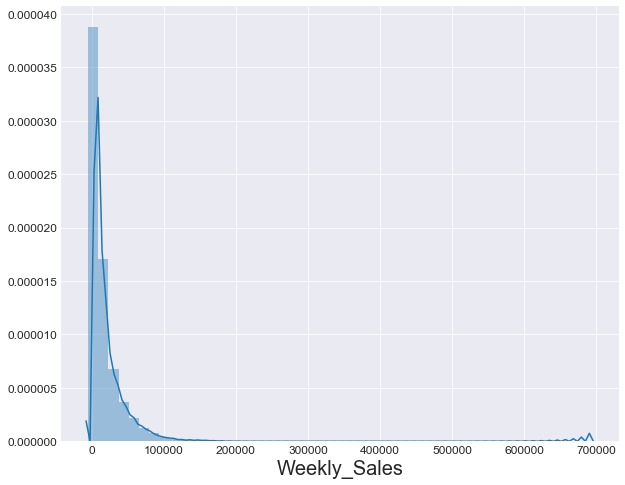

In [7]:
plt.figure(figsize=(10,8))
sns.distplot(dados.Weekly_Sales)

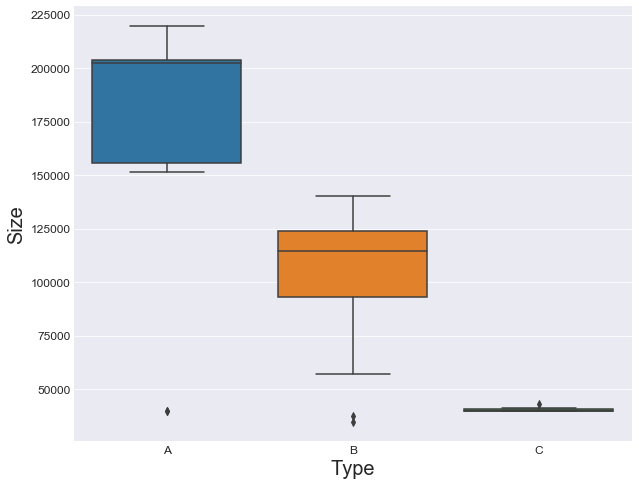

In [8]:
plt.figure(figsize=(10,8))
sns.boxplot(x="Type", y="Size", data=lojas)

Podemos perceber que a classificação de lojas no Tipo tem uma forte correlação com o tamanho. 
Podemos assim utilizar apenas o tamanho nas nossas predições, afim de diminuir os parâmetros

In [9]:
vendas_lojas = dados
vendas_lojas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


Outro tratamento importante é o tratamento de departamento e loja. 
Por mais que departamento seja uma variável numérica, ela se comporta como uma variável categórica. Não sabemos se os valores de departamentos tem função de peso, ou apenas são as categorias dos mesmos, isto posto vamos fazer uma avaliação rápida sobre o comportamento das vendas por departamento

In [10]:
#distribuicao_dept = dados.merge(dados.groupby(['Store','Date']).sum()['Weekly_Sales'].reset_index(), on=['Store', 'Date'], how='left')

In [11]:
#distribuicao_dept['%loja'] = distribuicao_dept['Weekly_Sales_x']/distribuicao_dept['Weekly_Sales_y']
#distribuicao_dept

In [12]:
#for i in range (1,45):
#    plt.figure(figsize=(30,8))
#    sns.boxplot(x="Dept", y="%loja", data=distribuicao_dept.loc[distribuicao_dept['Store'] == i])

Podemos notar que as variáveis de departamento não são variáveis quantitativas, apenas categóricas, pois o comportamento das vendas semanais não tem uma distribuição correlacionada com os valores dos departamentos.
Por outro lado, podemos notar que os departamentos tem um comportamento razoavelmente bem comportado em realação ao total de vendas das lojas, portanto iremos utilizar essa informação para nos auxiliar na predição por departamento, uma vez que as features que vamos utilizar estão quebradas apenas por lojas.

In [13]:
#tabela_dept = pd.pivot_table(dados, values='Weekly_Sales', index=['Store','Date'],
#                    columns=['Dept'], aggfunc=np.sum).fillna(0).reset_index()
#vendas_completas = vendas_lojas.merge(tabela_dept, on=['Store','Date'], how='left')

In [14]:
#vendas_percentuais = vendas_completas[['Store','Date','Weekly_Sales']]

#for i in range (len(vendas_completas.columns)-3) :
#    vendas_percentuais[vendas_completas.columns[i+3]] = (vendas_completas[vendas_completas.columns[i+3]]/vendas_completas['Weekly_Sales'])



#vendas_percentuais_lojas = vendas_percentuais.groupby('Store').mean().round(3)
#vendas_percentuais_lojas

Vamos portanto utilizar o agregado por loja para agrupar as features e começar nosso tratamento

In [15]:
valores_por_loja = dados#.groupby(['Store','Date','IsHoliday']).sum()['Weekly_Sales'].reset_index()

In [16]:
valores_por_loja_tamanho = valores_por_loja.merge(lojas, on='Store', how='left')

In [17]:
lojas_completas = valores_por_loja_tamanho.merge(features, on=['Store','Date'], how='left')

In [18]:
lojas_completas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
dtypes: bool(2), float64(10), int64(3), object(2)
mem

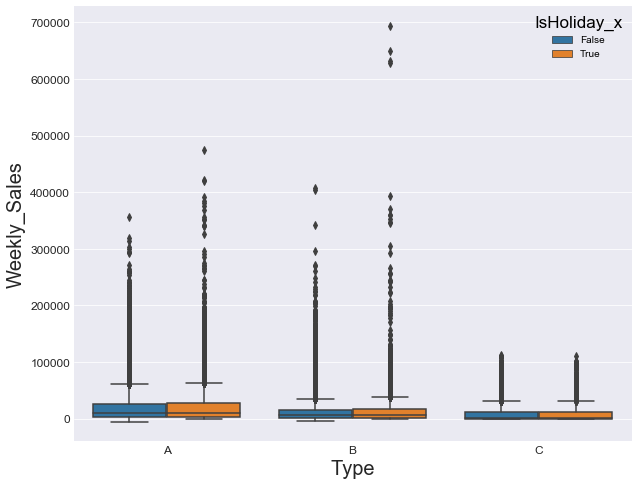

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x="Type", y="Weekly_Sales",hue='IsHoliday_x', data=lojas_completas)

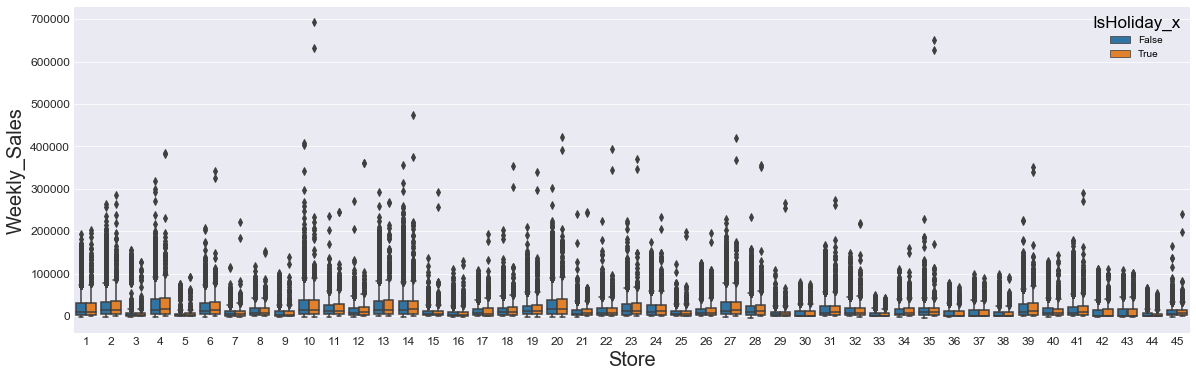

In [20]:
plt.figure(figsize=(20,6))
sns.boxplot(x="Store", y="Weekly_Sales",hue='IsHoliday_x', data=lojas_completas)

In [21]:
vendas_no_tempo = lojas_completas.groupby(['Date','Type']).mean()['Weekly_Sales'].reset_index()

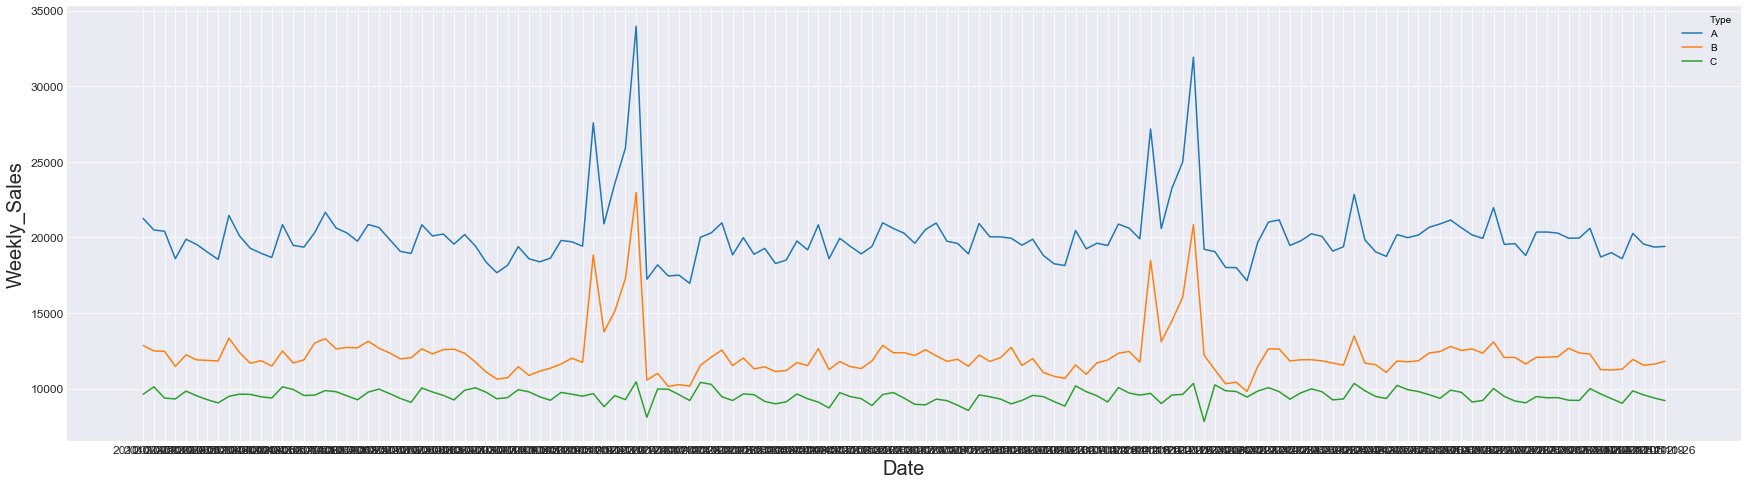

In [22]:
plt.figure(figsize=(30,8))
sns.lineplot(x="Date", y="Weekly_Sales",hue='Type', data=vendas_no_tempo)

In [23]:
feriados = {
    'Date' : (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',
                             '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',
                            '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',
                            '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']),
    'TypeHoliday' :(['SB', 'SB', 'SB', 'SB',
                    'Labor', 'Labor', 'Labor', 'Labor',
                    'Thanksgiving', 'Thanksgiving', 'Thanksgiving', 'Thanksgiving',
                    'Christmas', 'Christmas', 'Christmas', 'Christmas']) 

}

In [145]:
lojas_feriados = lojas_completas.merge(pd.DataFrame(feriados), on='Date', how='left')
lojas_feriados['TypeHoliday'].fillna(0,inplace=True)
lojas_feriados

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,TypeHoliday
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,0
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,SB
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,0
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,0
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False,0
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False,0
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False,0
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False,0


Vamos analisar as vendas de feriados, antes de analisarmos os descontos

Antes de começar os testes de modelos, vamos tratar os valores faltantes. 
Nota-se que os MarkDowns são os unicos valores faltantes neste dataset, e considerando a documentação e a natureza dessas features vamos fazer uma rápida análise para verificar o comportamento dessas variáveis.

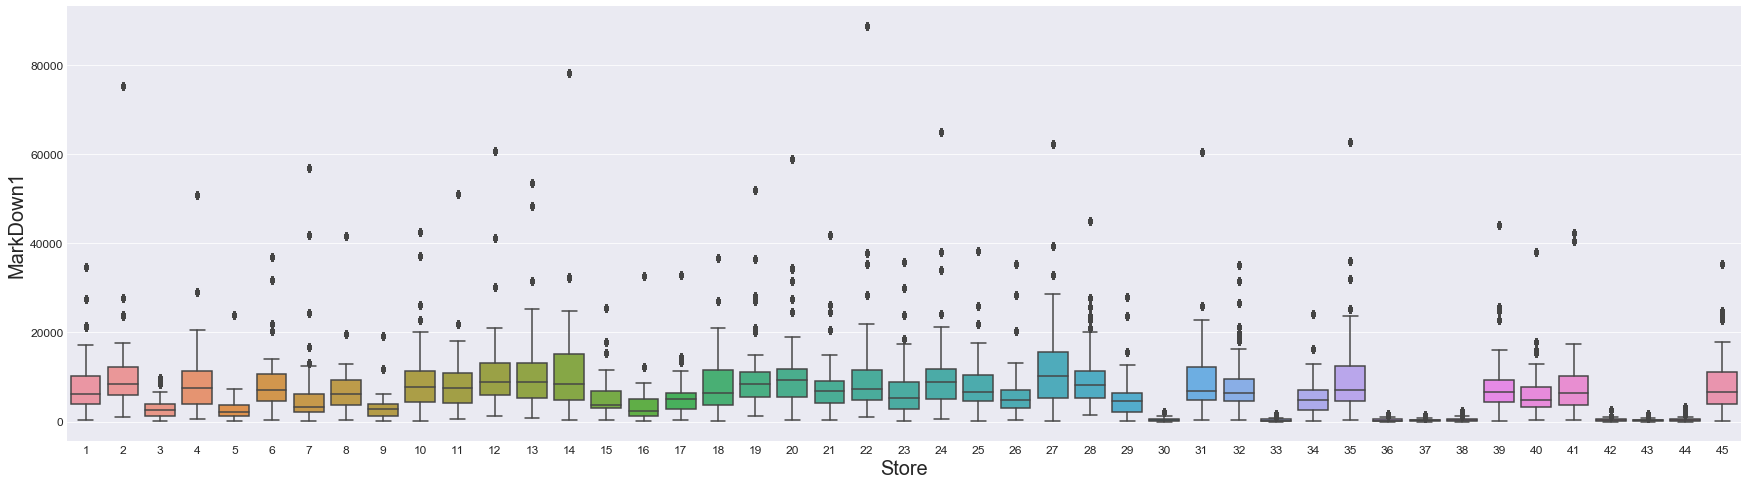

In [25]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="MarkDown1", data=lojas_feriados)

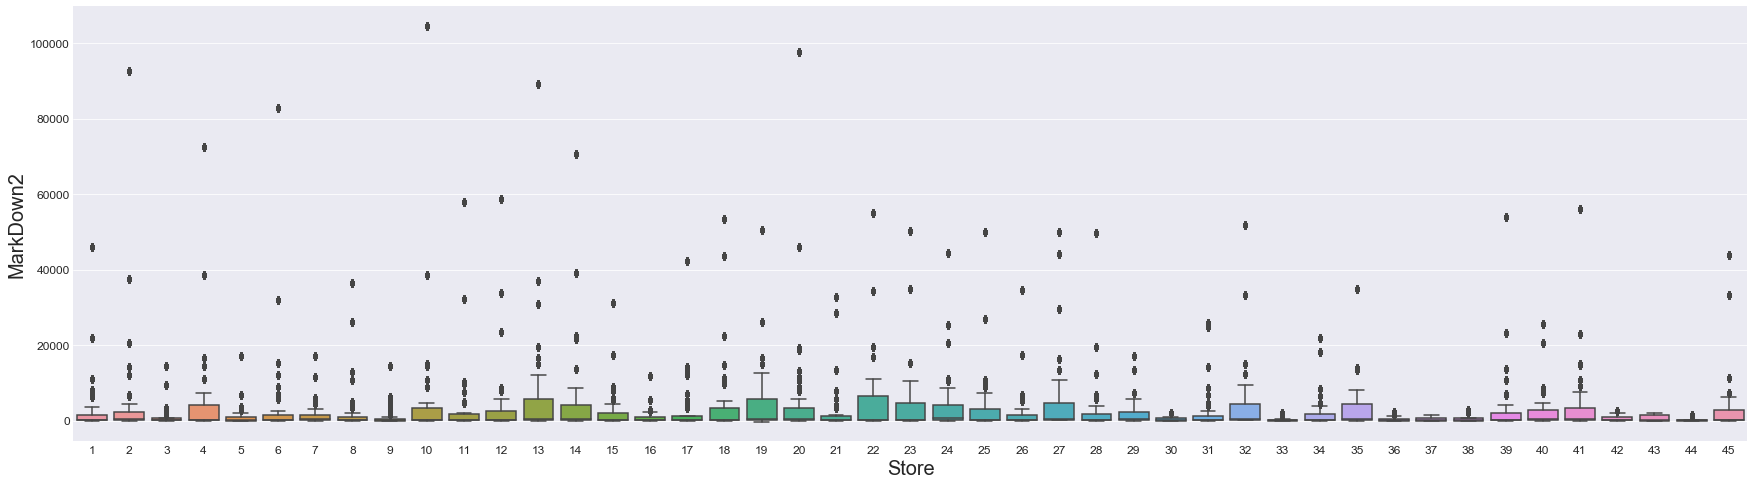

In [26]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="MarkDown2", data=lojas_feriados)

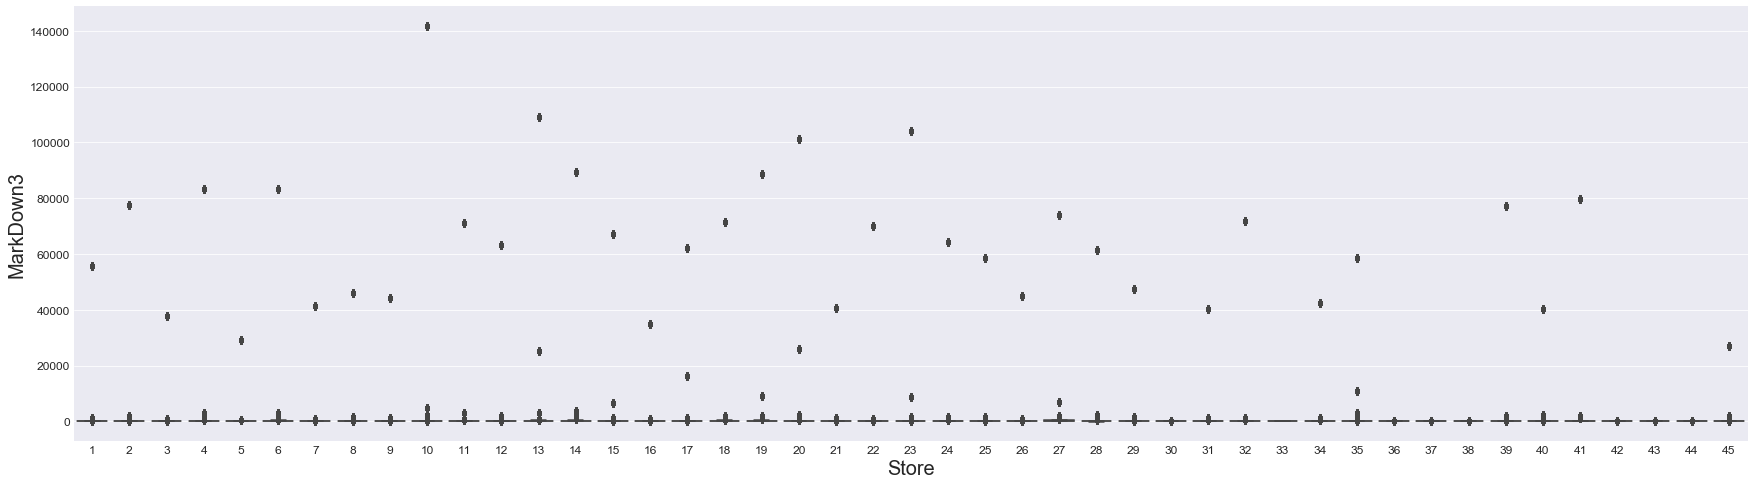

In [27]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="MarkDown3", data=lojas_feriados)

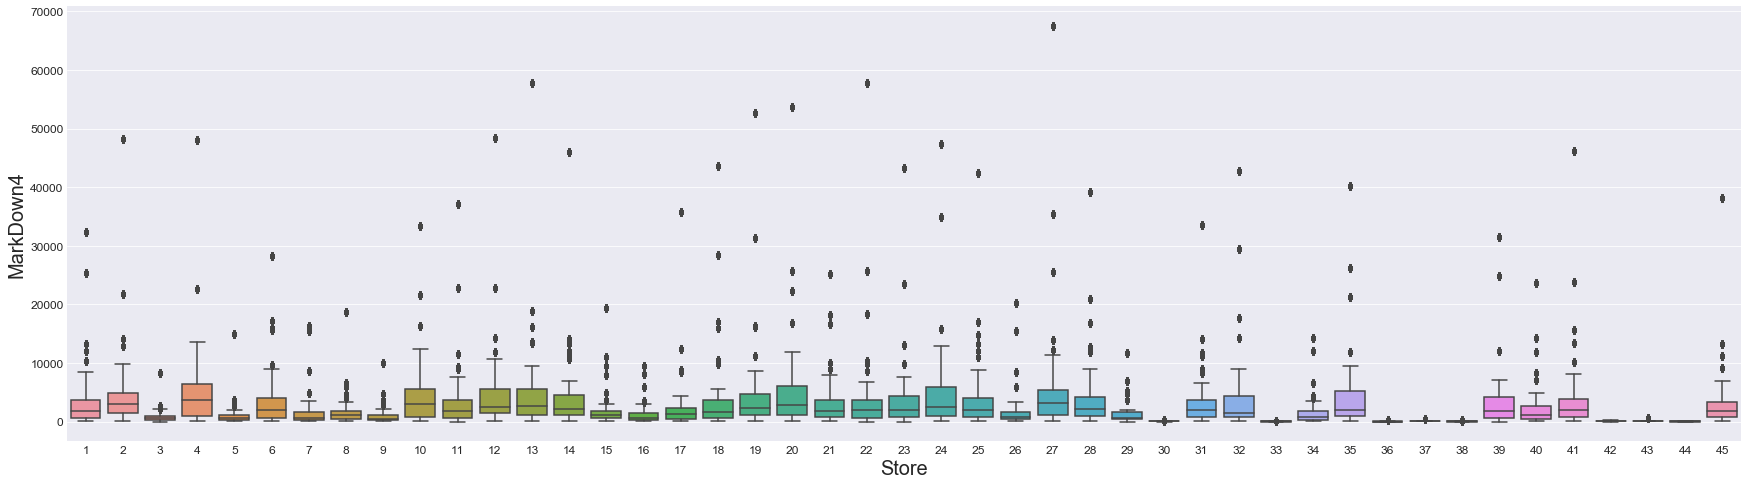

In [28]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="MarkDown4", data=lojas_feriados)

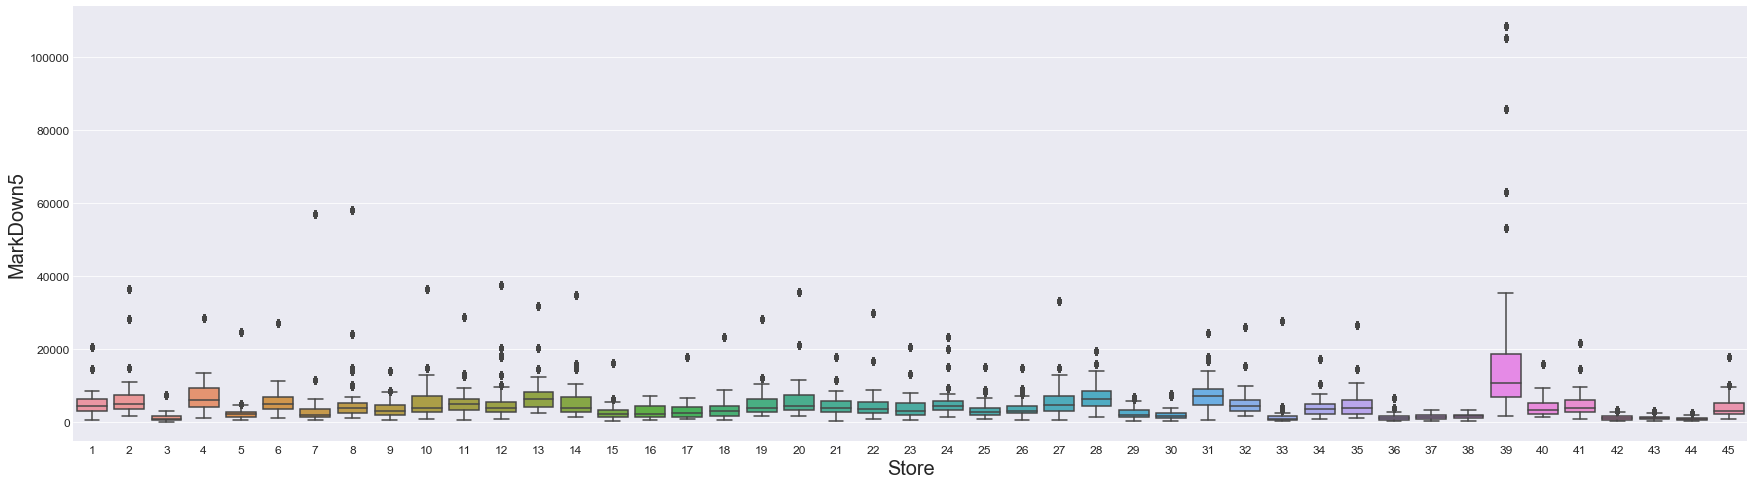

In [29]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="MarkDown5", data=lojas_feriados)

Todos os MarkDowns tem pouca variabilidade, porém bastantes outliers. Com essa informação podemos preencher os valores faltantes pela mediana de cada markdown em cada loja.

In [30]:
filling = lojas_feriados.groupby(['Store','IsHoliday_x','Type']).median()[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].reset_index()
filling.rename(columns={'MarkDown1':'FMD1','MarkDown2':'FMD2','MarkDown3':'FMD3','MarkDown4':'FMD4','MarkDown5':'FMD5'}, inplace=True)

In [31]:
lojas_preenchidas = lojas_feriados.merge(filling, on=['Store','IsHoliday_x','Type'], how='inner')

In [32]:
lojas_preenchidas.MarkDown1.fillna(lojas_preenchidas['FMD1'],inplace=True)
lojas_preenchidas.MarkDown2.fillna(lojas_preenchidas['FMD2'],inplace=True)
lojas_preenchidas.MarkDown3.fillna(lojas_preenchidas['FMD3'],inplace=True)
lojas_preenchidas.MarkDown4.fillna(lojas_preenchidas['FMD4'],inplace=True)
lojas_preenchidas.MarkDown5.fillna(lojas_preenchidas['FMD5'],inplace=True)
lojas_preenchidas.drop(['FMD1','FMD2','FMD3','FMD4','FMD5'], axis=1, inplace=True)
lojas_preenchidas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
 17  TypeHoliday   421570 non-null  object 
dtypes: b

Com os valores preenchidos, vamos analisar o comportamento das variáveis dentro do dataset

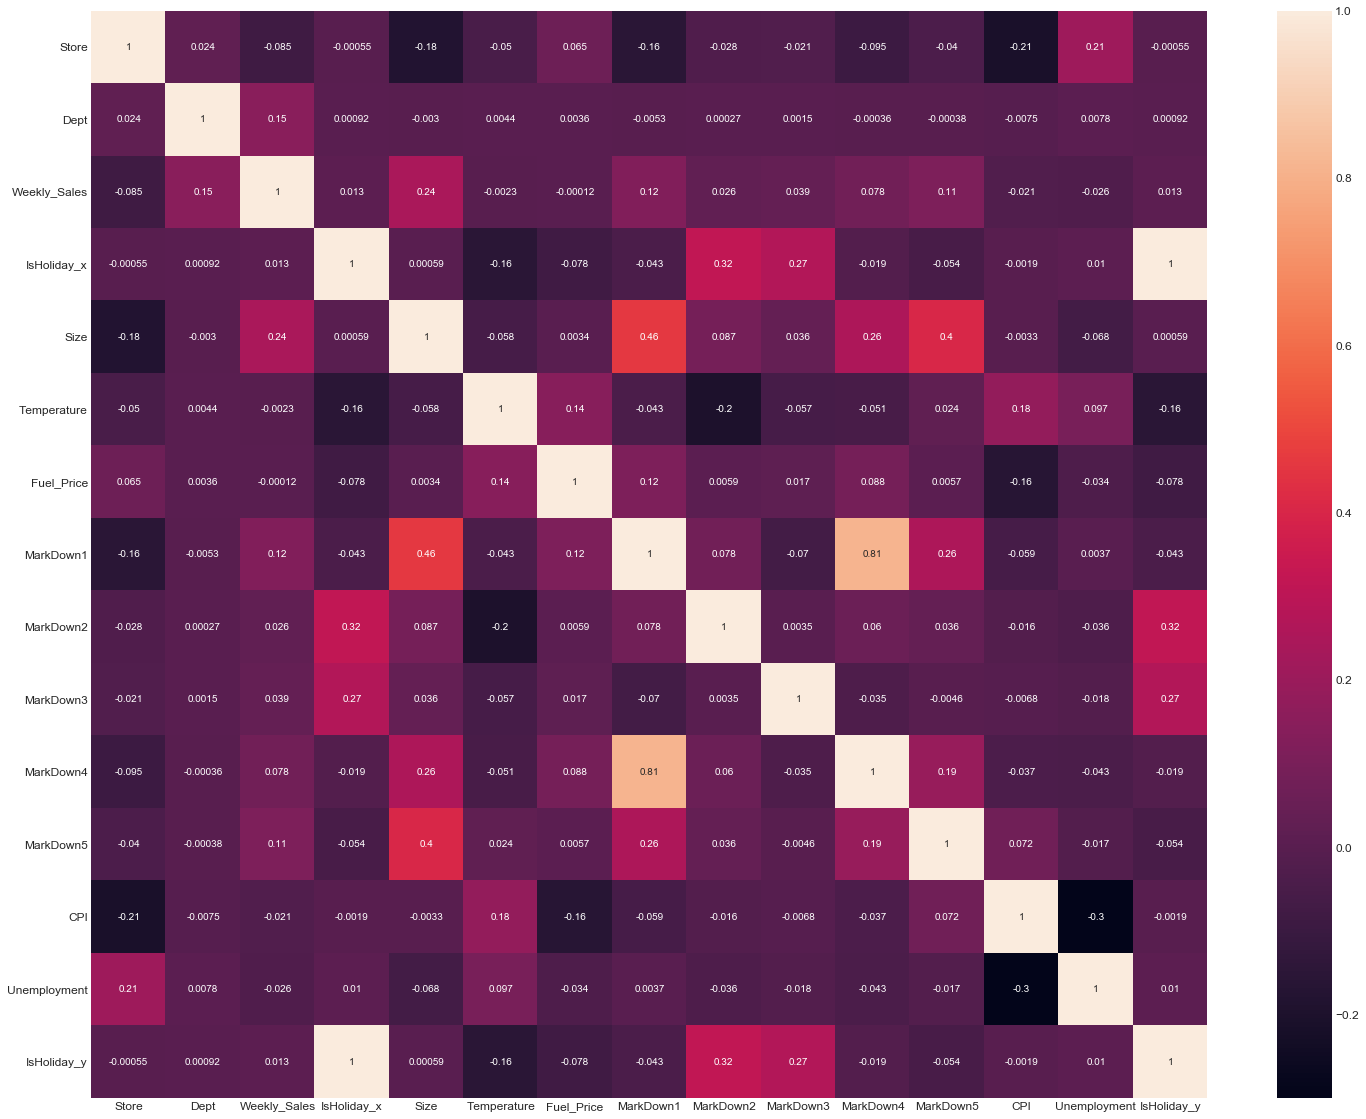

In [33]:
plt.figure(figsize=(25,20))
sns.heatmap(lojas_preenchidas.fillna(0).corr(), annot=True)

Podemos verificar que os MarDowns tem forte correlação entre si, e alguma correlação com a variável que queremos predizer. 
Vamos portanto retirar alguns MarkDowns para evitar problemas de coliearidade futuro.

In [34]:
pd.get_dummies(lojas_preenchidas.TypeHoliday)['SB']

0         0
1         0
2         0
3         0
4         0
         ..
421565    0
421566    0
421567    0
421568    1
421569    0
Name: SB, Length: 421570, dtype: uint8

In [35]:
lojas_preenchidas['IsHoliday'] = pd.get_dummies(lojas_preenchidas.IsHoliday_x)[1]
lojas_preenchidas['SB'] =pd.get_dummies(lojas_preenchidas.TypeHoliday)['SB']
lojas_preenchidas['Labor'] =pd.get_dummies(lojas_preenchidas.TypeHoliday)['Labor']
lojas_preenchidas['Thanksgiving'] =pd.get_dummies(lojas_preenchidas.TypeHoliday)['Thanksgiving']
lojas_preenchidas['Christmas'] =pd.get_dummies(lojas_preenchidas.TypeHoliday)['Christmas']
lojas_preenchidas

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown5,CPI,Unemployment,IsHoliday_y,TypeHoliday,IsHoliday,SB,Labor,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,6186.19,...,4325.19,211.096358,8.106,False,0,0,0,0,0,0
1,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,6186.19,...,4325.19,211.289143,8.106,False,0,0,0,0,0,0
2,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,6186.19,...,4325.19,211.319643,8.106,False,0,0,0,0,0,0
3,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,6186.19,...,4325.19,211.350143,8.106,False,0,0,0,0,0,0
4,1,1,2010-03-12,21043.39,False,A,151315,57.79,2.667,6186.19,...,4325.19,211.380643,8.106,False,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2011-09-09,1092.66,True,B,118221,71.48,3.738,11024.45,...,2055.70,186.673738,8.625,True,Labor,1,0,1,0,0
421566,45,98,2011-11-25,794.62,True,B,118221,48.71,3.492,140.87,...,1110.12,188.350400,8.523,True,Thanksgiving,1,0,0,1,0
421567,45,98,2011-12-30,553.21,True,B,118221,37.79,3.389,3604.35,...,750.01,189.062016,8.523,True,Christmas,1,0,0,0,1
421568,45,98,2012-02-10,770.86,True,B,118221,37.00,3.640,15760.30,...,4685.58,189.707605,8.424,True,SB,1,1,0,0,0


In [36]:
lojas_preenchidas['TypeA'] = pd.get_dummies(lojas_preenchidas.Type)['A']
lojas_preenchidas['TypeB'] = pd.get_dummies(lojas_preenchidas.Type)['B']
lojas_preenchidas['TypeC'] = pd.get_dummies(lojas_preenchidas.Type)['C']

In [37]:
lojas_preenchidas['Month'] = pd.to_datetime(lojas_preenchidas.Date).dt.month
lojas_preenchidas['Year'] = pd.to_datetime(lojas_preenchidas.Date).dt.year

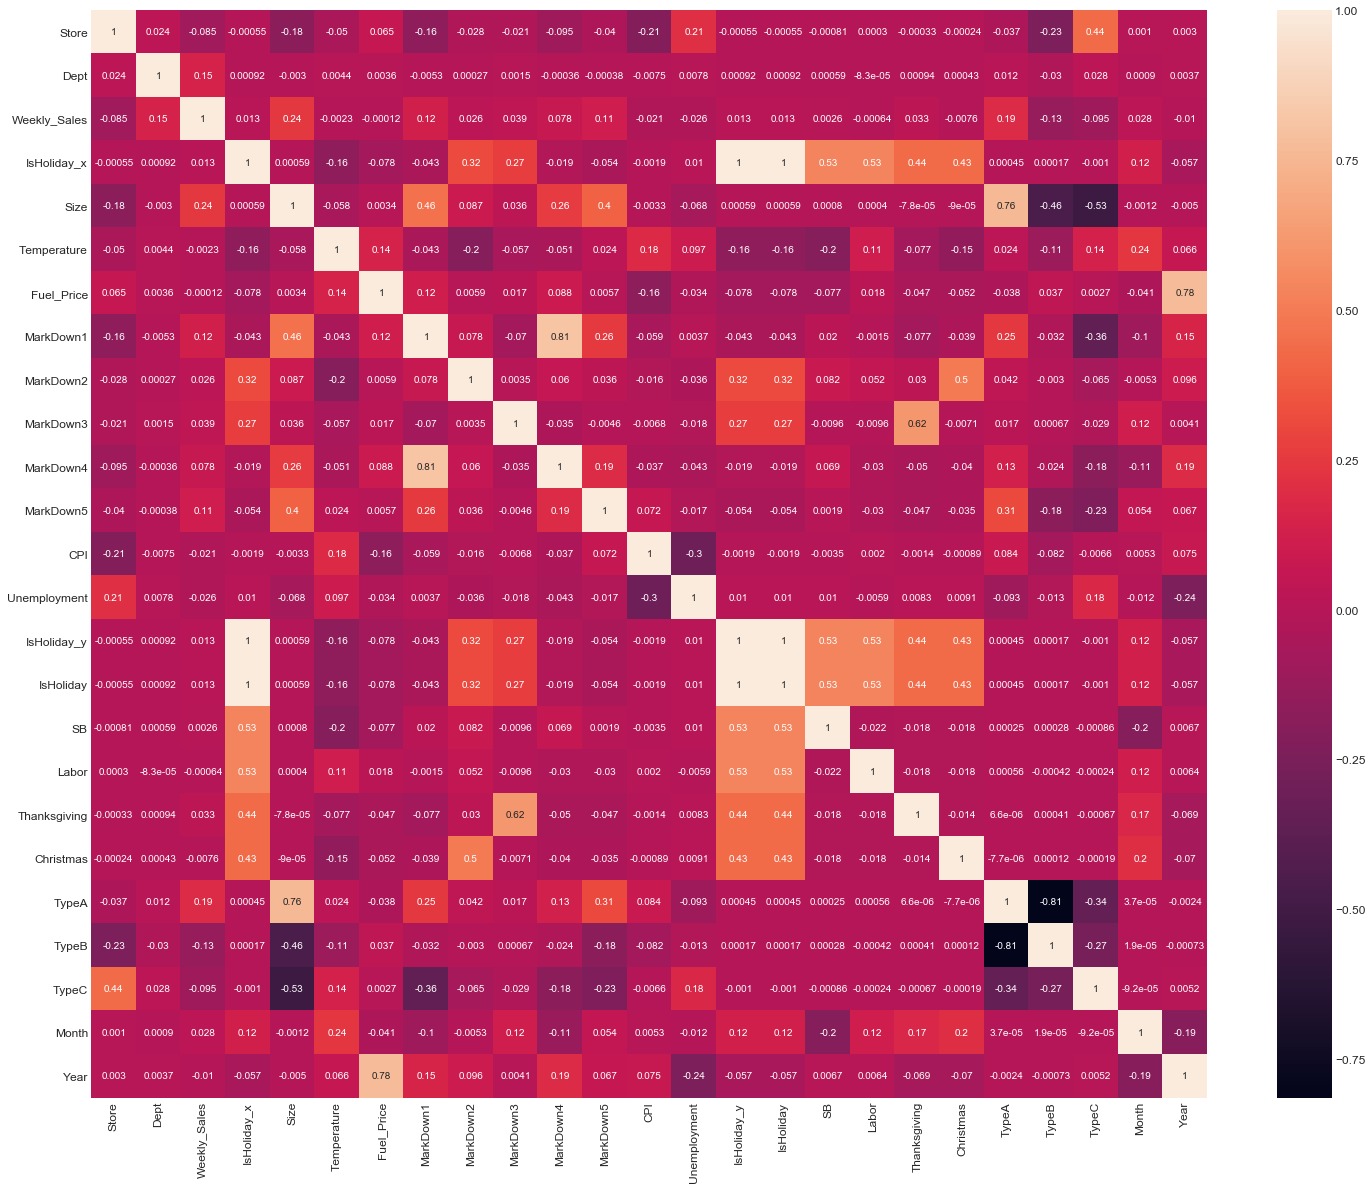

In [38]:
plt.figure(figsize=(25,20))
sns.heatmap(lojas_preenchidas.fillna(0).corr(), annot=True)

Conforme nossa primeira suposição os tipos de loja tem uma correlação considerável com o nosso tamanho de loja, vamos deixar essas variáveis fora do modelo

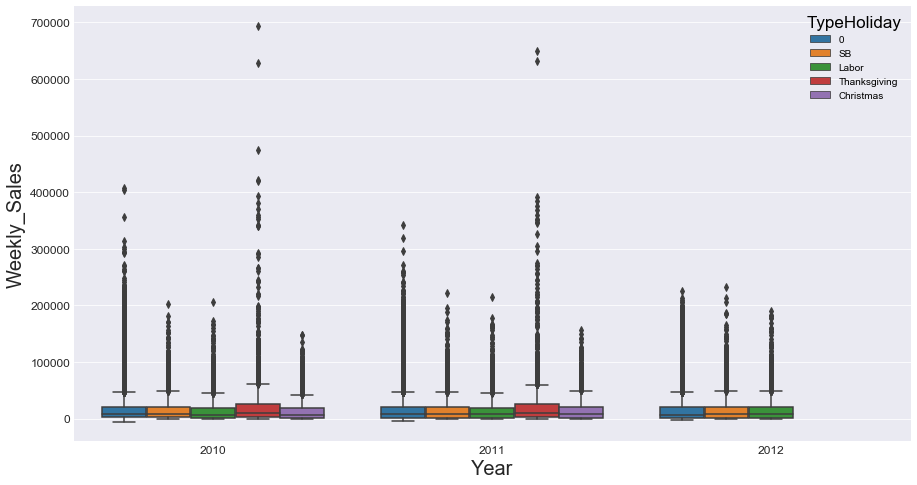

In [39]:
plt.figure(figsize=(15,8))
sns.boxplot(x="Year", y="Weekly_Sales",hue='TypeHoliday', data=lojas_preenchidas)

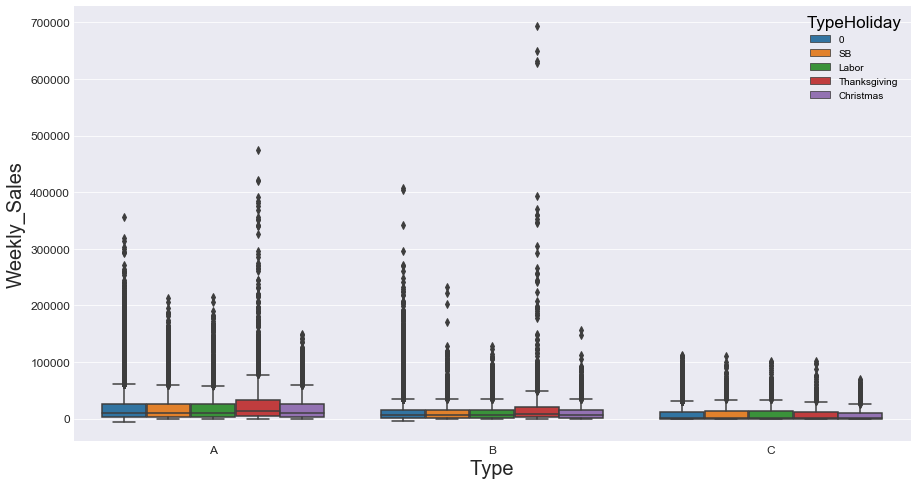

In [40]:
plt.figure(figsize=(15,8))
sns.boxplot(x="Type", y="Weekly_Sales",hue='TypeHoliday', data=lojas_preenchidas)

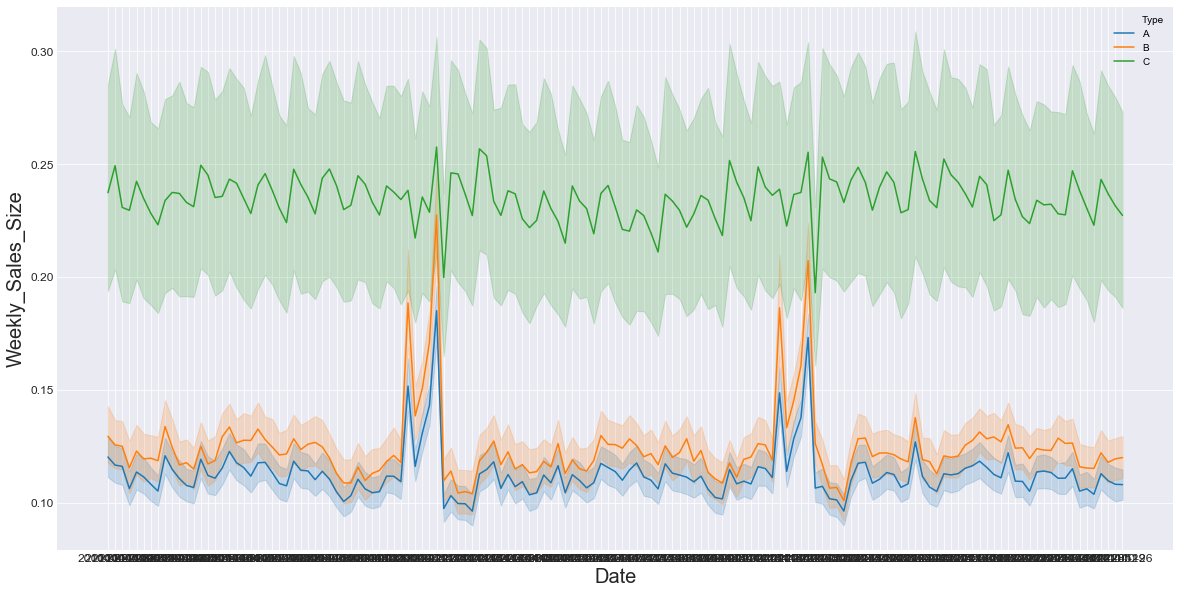

In [41]:
plt.figure(figsize=(20,10))
lojas_preenchidas['Weekly_Sales_Size'] = lojas_preenchidas['Weekly_Sales']/lojas_preenchidas['Size']
sns.lineplot(x="Date", y="Weekly_Sales_Size",hue='Type', data=lojas_preenchidas)

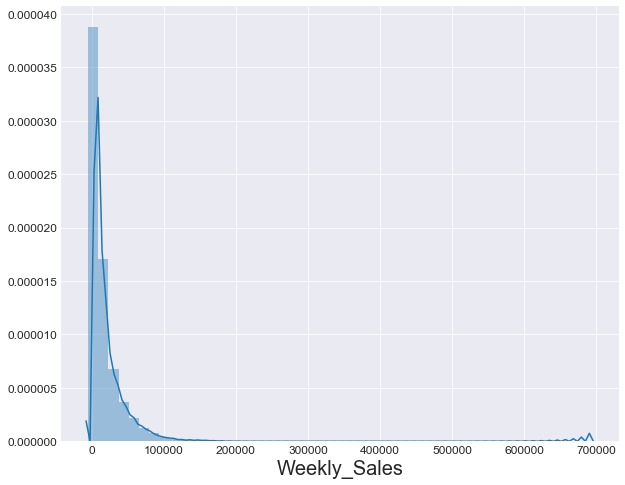

In [42]:
plt.figure(figsize=(10,8))
sns.distplot(lojas_preenchidas.Weekly_Sales)

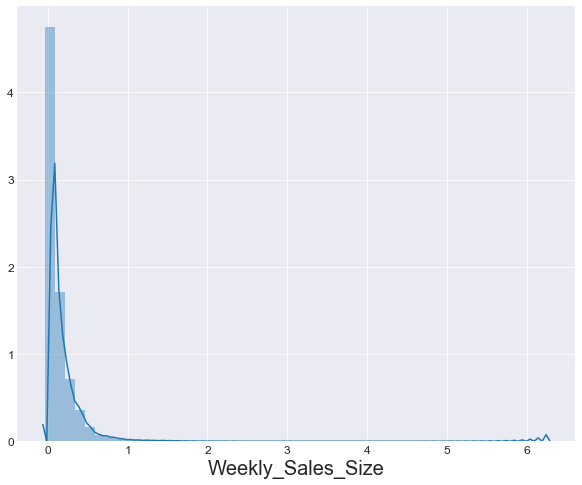

In [43]:
plt.figure(figsize=(10,8))
sns.distplot(lojas_preenchidas.Weekly_Sales_Size)

In [44]:
lojas_limpas = lojas_preenchidas.drop(['IsHoliday_y','IsHoliday_x','Type','TypeHoliday','Weekly_Sales_Size'], axis=1)

In [45]:
lojas_limpas = lojas_preenchidas.drop(['MarkDown4','MarkDown5','IsHoliday_y','IsHoliday_x','Type','TypeHoliday','TypeC','Weekly_Sales_Size'], axis=1)

O MarkDown1 tem uma correção razoável com o Size, porém dado sua forte correção com a variável resposta vamos manter no nosso conjunto de Features por enquanto. Caso seja necessário faremos a limpeza depois

Selecionados os conjuntos de variáveis iniciais vamos tratar os conjuntos de dados a serem treinados e testados

# Modelo

Para iniciar o modelo, além de Dept, vamos retirar a variável Store. Isso porque não queremos ter uma falsa visão de que a loja impacta nas suas vendas, sendo apenas uma variável categórica. 
Além disso vamos dividir 3 conjuntos de dados, os dados de treino, os dados de teste out-of-sample e os dados out-of-time. 
Isso porque como as nossas vendas ocorrem no tempo queremos garantir que o modelo se comporte de mandeira consistente para futuras predições.

Para nossa amostra OfT vamos considerar o último quarto de vendas

In [46]:
OfT = lojas_limpas.loc[lojas_limpas['Date'] >= '2012-10-05']
lojas_predict = lojas_limpas.loc[lojas_limpas['Date'] < '2012-10-05']

Agora vamos quebrar os conjuntos de X e y

In [47]:
# Conjunto OfT
X_OfT = OfT.drop(['Weekly_Sales','Date'], axis=1)
y_OfT = OfT['Weekly_Sales']
# Conjunto OfS
X = lojas_predict.drop(['Weekly_Sales','Date'], axis=1)
y = lojas_predict['Weekly_Sales']

In [48]:
X_OfT

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,IsHoliday,SB,Labor,Thanksgiving,Christmas,TypeA,TypeB,TypeC,Month,Year
129,1,1,151315,68.55,3.617,8077.89,137.86,18.22,3617.43,3626.14,...,0,0,0,0,0,1,0,0,10,2012
130,1,1,151315,62.99,3.601,2086.18,137.86,8.11,602.36,5926.45,...,0,0,0,0,0,1,0,0,10,2012
131,1,1,151315,67.97,3.594,950.33,137.86,4.93,80.25,2312.85,...,0,0,0,0,0,1,0,0,10,2012
132,1,1,151315,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,...,0,0,0,0,0,1,0,0,10,2012
262,1,2,151315,68.55,3.617,8077.89,137.86,18.22,3617.43,3626.14,...,0,0,0,0,0,1,0,0,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420764,45,97,118221,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,...,0,0,0,0,0,0,1,0,10,2012
420886,45,98,118221,64.89,3.985,5046.74,169.00,18.82,2253.43,2340.01,...,0,0,0,0,0,0,1,0,10,2012
420887,45,98,118221,54.47,4.000,1956.28,169.00,7.89,599.32,3990.54,...,0,0,0,0,0,0,1,0,10,2012
420888,45,98,118221,56.47,3.969,2004.02,169.00,3.18,437.73,1537.49,...,0,0,0,0,0,0,1,0,10,2012


Para coparar os modelos que iremos ajustat, além da função do Score do modelo e do R², iremos usar a função determinada pelo desafio de WMAE

In [49]:
def WMAE(y_obs, y_pred, flag):
    peso = flag*5+1*(1-flag)
    
    indice = (1/sum(peso))*sum(peso*abs(y_obs-y_pred))

    return indice

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [51]:
X_train.shape

(307271, 22)

In [52]:
X_test.shape

(102424, 22)

## Os modelos

Escolhi três modelos para comparar performance e verificar qual seria o modelo adotado para esse caso: LinearRegression, RandomForestRegressor e GradientBoostRegressor. Cada um dos tres modelos tem uma especificidade para como fitam os dados, portanto vamos olhar todos

### Regressão Linear

Vamos usar o método de CrossValidation para veirificar a coerência dos nossos modelos, assim como sua estabilidade nos conjuntos de dados. Usaremos também o GridSearch para vefiricar quais os parâmentros ótimos de cada modelo que estamos utilizando.

In [ ]:
parameters = {'normalize': [False,True], 'fit_intercept': [False,True]} 
model = LinearRegression()

SEED = 1988
np.random.seed(SEED)
cv = KFold(10, shuffle=True)



clf = GridSearchCV(model, parameters, cv=cv, verbose=5, n_jobs=8)
clf.fit(X_train, y_train)
clf.best_params_
clf.predict(X_test)
wmae = WMAE(y_test, clf.predict(X_test), X_test.IsHoliday)
r2 = r2_score(y_test, clf.predict(X_test))
results = cross_validate(model, X, y, cv=cv, return_train_score = False)
media = results['test_score'].mean()
desvio = results['test_score'].std()

print("LinearRegression")
print("------------------------------")
print(f'Parametros ótimos = {clf.best_params_}')
print(f'Mean: {media*100}')
print(f'Accuracy: [{(media-2*desvio)*100} , {(media+2*desvio)*100}]')
print(f'WMAE = {wmae} and R-square = {r2}')
print("------------------------------")

SEED = 1988
np.random.seed(SEED)
parameters = {'max_depth': [10,20,25,30],'max_features': [6,8,12] , 'n_estimators' : [300, 800, 1600], 'min_samples_leaf' : [2,5]}
model = RandomForestRegressor()


#weight = X_train.IsHoliday*5+1*(1-X_train.IsHoliday)

clf = GridSearchCV(model, parameters, cv=10, verbose=5, n_jobs=8)
clf.fit(X_train, y_train)#, sample_weight=weight )
clf.best_params_
clf.predict(X_test)
wmae = WMAE(y_test, clf.predict(X_test), X_test.IsHoliday)
r2 = r2_score(y_test, clf.predict(X_test))


print("RandomForest")
print("------------------------------")
print(f'Parametros ótimos = {clf.best_params_}')
print(f'WMAE = {wmae} and R-square = {r2}')
print("------------------------------")

parameters = {'max_depth': [3,5,7], 'max_features': [6,8,12], 'n_estimators' : [300, 800, 1600], 'min_samples_leaf' : [2,5]}
model = GradientBoostingRegressor()

SEED = 1988
np.random.seed(SEED)


#weight = X_train.IsHoliday*5+1*(1-X_train.IsHoliday)

clf = GridSearchCV(model, parameters, cv=10, verbose=5, n_jobs=8)
clf.fit(X_train, y_train)#, sample_weight=weight )
clf.best_params_
clf.predict(X_test)
wmae = WMAE(y_test, clf.predict(X_test), X_test.IsHoliday)
r2 = r2_score(y_test, clf.predict(X_test))

print("GradientBoosting")
print("------------------------------")
print(f'Parametros ótimos = {clf.best_params_}')
print(f'WMAE = {wmae} and R-square = {r2}')
print("------------------------------")

## Análise de resultados

In [182]:
SEED = 1988
np.random.seed(SEED)
ln = LinearRegression(fit_intercept = True, normalize = False)
rf = RandomForestRegressor(max_depth = 30, max_features =  18, min_samples_leaf = 2 ,n_estimators = 300)
gbm = GradientBoostingRegressor(max_depth = 5, max_features = 12, min_samples_leaf = 5, n_estimators = 300)
np.random.seed(SEED)

ln.fit(X_train, y_train)
ln_y_pred = ln.predict(X_test)
wmae_ln_pred = WMAE(y_test, ln_y_pred, X_test.IsHoliday)
r2_ln_pred = r2_score(y_test, ln_y_pred)

rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
wmae_rf_pred = WMAE(y_test, rf_y_pred, X_test.IsHoliday)
r2_rf_pred = r2_score(y_test, rf_y_pred)

gbm.fit(X_train, y_train)
gbm_y_pred = gbm.predict(X_test)
wmae_gbm_pred = WMAE(y_test, gbm_y_pred, X_test.IsHoliday)
r2_gbm_pred = r2_score(y_test, gbm_y_pred)

print("LinearRegression")
print("------------------------------")
print(f'WMAE = {wmae_ln_pred} and R-square = {r2_ln_pred}')
print("------------------------------")
print("RandomForest")
print("------------------------------")
print(f'WMAE = {wmae_rf_pred} and R-square = {r2_rf_pred}')
print("------------------------------")
print("GradientBoosting")
print("------------------------------")
print(f'WMAE = {wmae_gbm_pred} and R-square = {r2_gbm_pred}')
print("------------------------------")

LinearRegression
------------------------------
WMAE = 14844.343370345536 and R-square = 0.09127721146691237
------------------------------
RandomForest
------------------------------
WMAE = 1862.4818752530618 and R-square = 0.9645107597352018
------------------------------
GradientBoosting
------------------------------
WMAE = 4025.116585726911 and R-square = 0.905022881981463
------------------------------


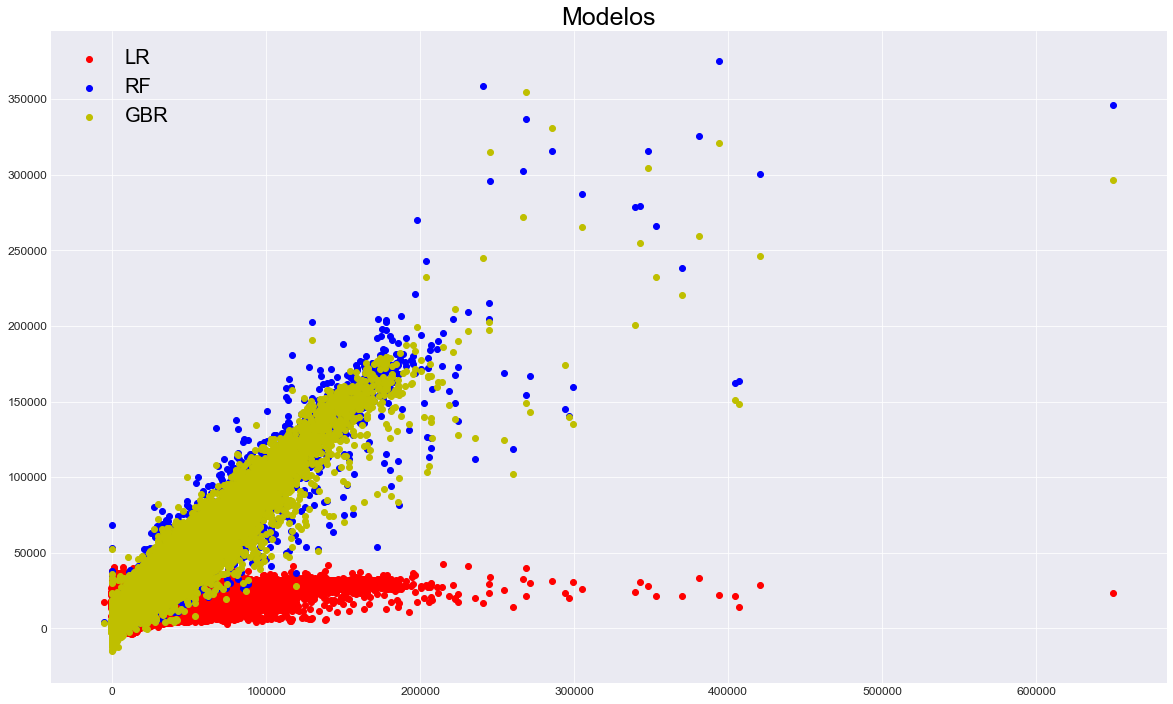

In [147]:
plt.figure(figsize = (20,12))
plt.scatter(y_test,ln_y_pred,label='LR',marker = 'o',color='r')
plt.scatter(y_test,rf_y_pred,label='RF',marker = 'o',color='b')
plt.scatter(y_test,gbm_y_pred,label='GBR',marker = 'o',color='y')
plt.title('Modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

### Teste Out of Time

In [148]:
ln_y_OfT = ln.predict(X_OfT)
wmae_ln_OfT = WMAE(y_OfT, ln_y_OfT, X_OfT.IsHoliday)
r2_ln_OfT = r2_score(y_OfT, ln_y_OfT)


rf_y_OfT = rf.predict(X_OfT)
wmae_rf_OfT = WMAE(y_OfT, rf_y_OfT, X_OfT.IsHoliday)
r2_rf_OfT = r2_score(y_OfT, rf_y_OfT)


gbm_y_OfT = gbm.predict(X_OfT)
wmae_gbm_OfT = WMAE(y_OfT, gbm_y_OfT, X_OfT.IsHoliday)
r2_gbm_OfT = r2_score(y_OfT, gbm_y_OfT)

print("LinearRegression")
print("------------------------------")
print(f'WMAE = {wmae_ln_OfT} and R-square = {r2_ln_OfT}')
print("------------------------------")
print("RandomForest")
print("------------------------------")
print(f'WMAE = {wmae_rf_OfT} and R-square = {r2_rf_OfT}')
print("------------------------------")
print("GradientBoosting")
print("------------------------------")
print(f'WMAE = {wmae_gbm_OfT} and R-square = {r2_gbm_OfT}')
print("------------------------------")

LinearRegression
------------------------------
WMAE = 14288.524366875437 and R-square = 0.09874496480906625
------------------------------
RandomForest
------------------------------
WMAE = 1837.7967575079717 and R-square = 0.9717760288643447
------------------------------
GradientBoosting
------------------------------
WMAE = 2972.5533359396654 and R-square = 0.9472447858255472
------------------------------


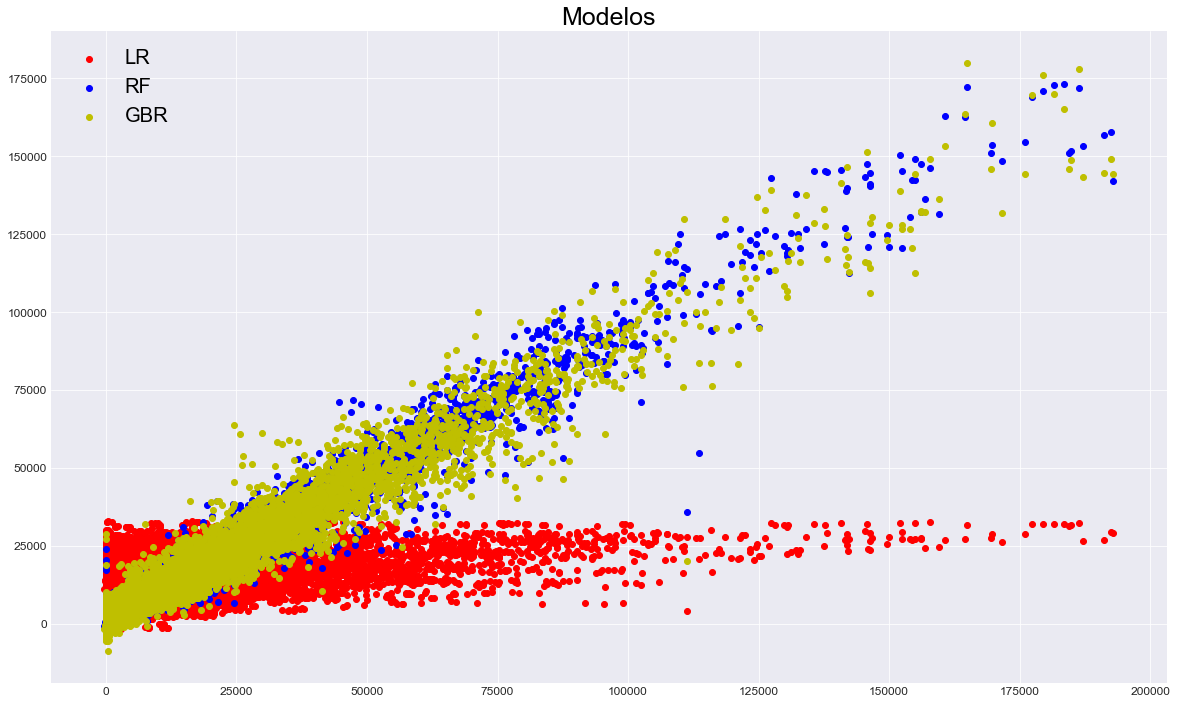

In [150]:
plt.figure(figsize = (20,12))
plt.scatter(y_OfT,ln_y_OfT,label='LR',marker = 'o',color='r')
plt.scatter(y_OfT,rf_y_OfT,label='RF',marker = 'o',color='b')
plt.scatter(y_OfT,gbm_y_OfT,label='GBR',marker = 'o',color='y')
plt.title('Modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

## Predição

In [151]:
predicoes_loja = predizer.merge(features, on=['Store','Date'], how='inner')

In [152]:
predicoes_loja.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday_x   115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  IsHoliday_y   115064 non-null  bool   
dtypes: bool(2), float64(9), int64(2), object(1)
memory usage: 11.6+ MB


In [61]:
#agrupado_loja_p = predizer.groupby(['Store','Date','IsHoliday']).count().reset_index()

In [153]:
lojas_p_features = predicoes_loja.merge(lojas, on='Store', how='inner')

In [154]:
lojas_p_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday_x   115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  IsHoliday_y   115064 non-null  bool   
 14  Type          115064 non-null  object 
 15  Size          115064 non-null  int64  
dtypes: bool(2), float64(9), int64(3), object(2)
memory usage: 13.4+ MB


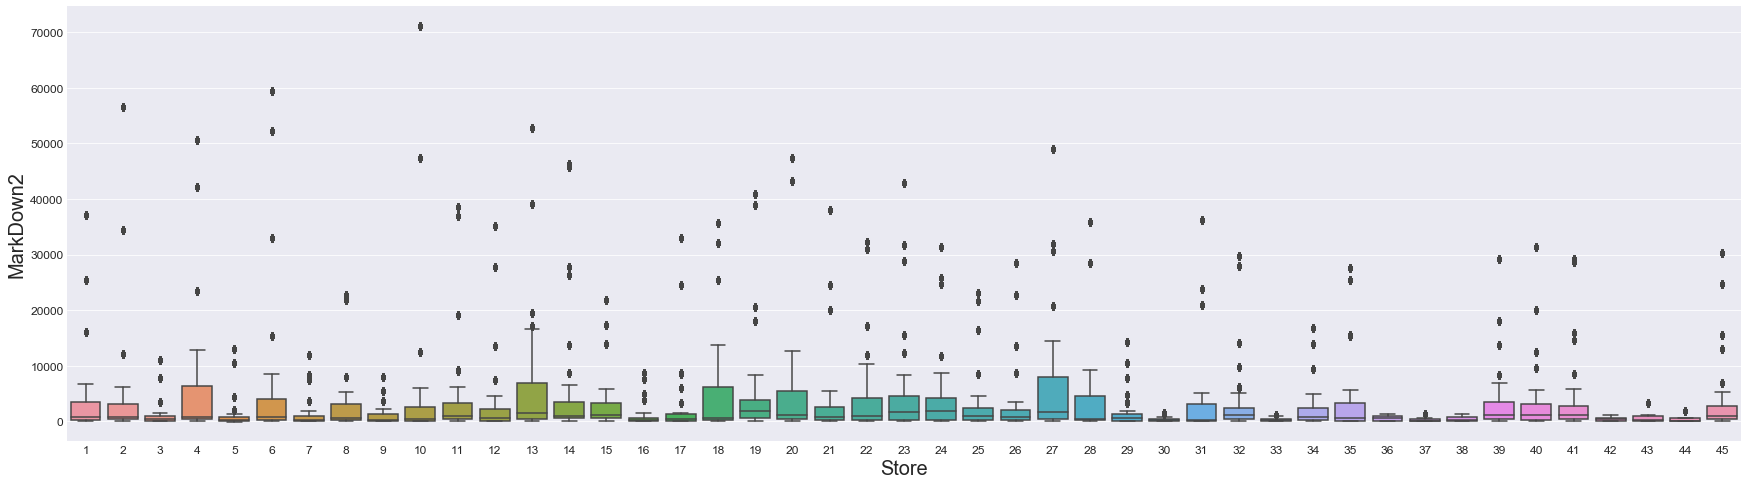

In [155]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="MarkDown2", data=lojas_p_features)

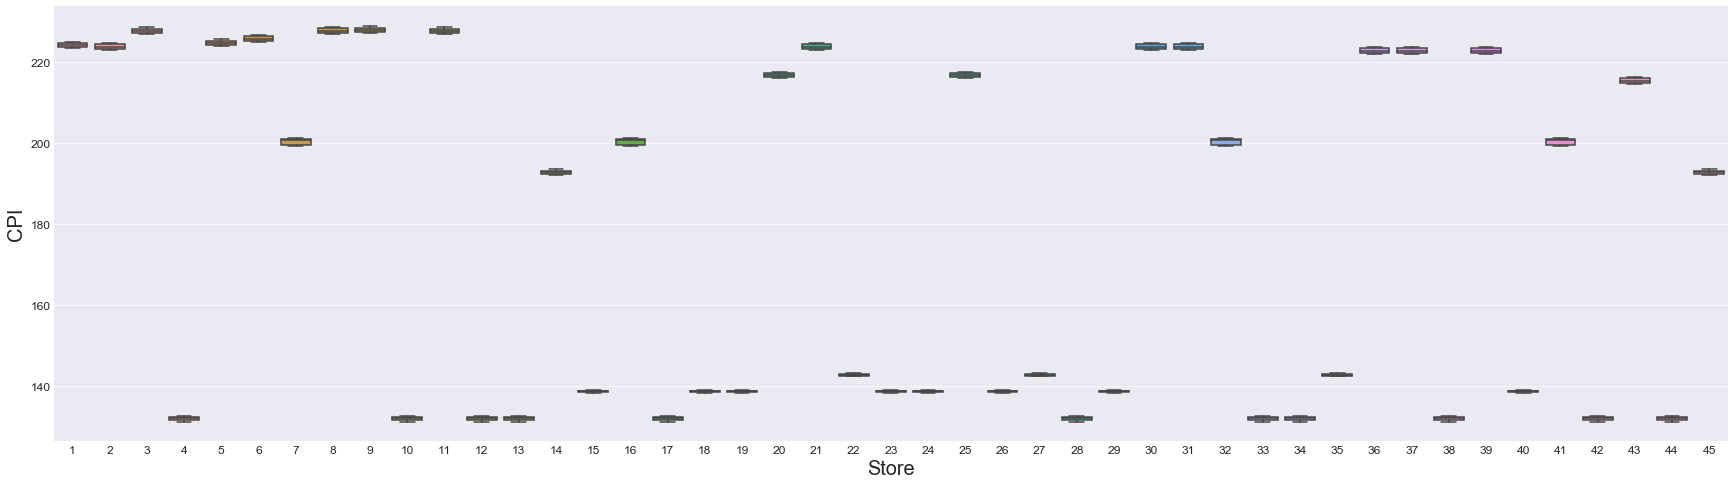

In [156]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="CPI", data=lojas_p_features)

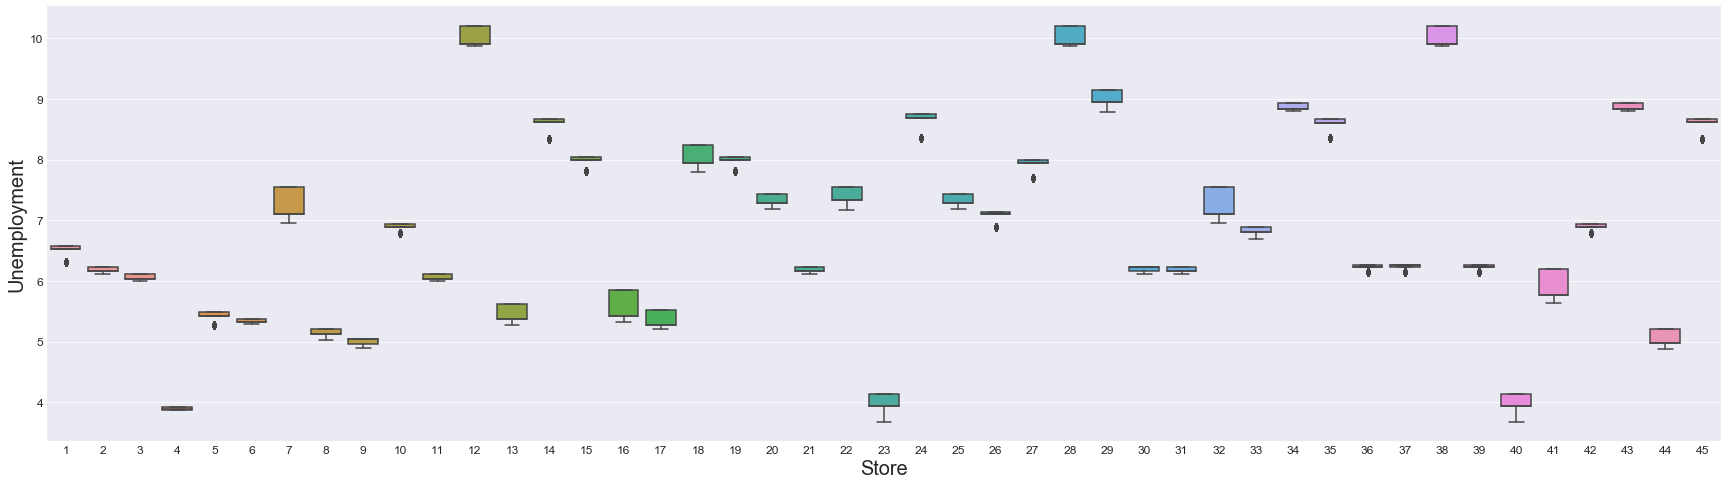

In [157]:
plt.figure(figsize=(30,8))
sns.boxplot(x="Store", y="Unemployment", data=lojas_p_features)

Vamos fazer o preenchimento dessas variáveis com o mesmo método que fizemos previamente, usando a mediana do período.

In [158]:
filling_p = lojas_p_features.groupby(['Store','IsHoliday_x','Type']).median()[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment']].reset_index()
filling_p.rename(columns={'MarkDown1':'FMD1','MarkDown2':'FMD2','MarkDown3':'FMD3','MarkDown4':'FMD4','MarkDown5':'FMD5','CPI': 'C','Unemployment':'UN'}, inplace=True)

In [159]:
lojas_preenchidas_p = lojas_p_features.merge(filling_p, on=['Store','IsHoliday_x'], how='inner')

In [160]:
lojas_preenchidas_p.MarkDown1.fillna(lojas_preenchidas_p['FMD1'],inplace=True)
lojas_preenchidas_p.MarkDown2.fillna(lojas_preenchidas_p['FMD2'],inplace=True)
lojas_preenchidas_p.MarkDown3.fillna(lojas_preenchidas_p['FMD3'],inplace=True)
lojas_preenchidas_p.MarkDown4.fillna(lojas_preenchidas_p['FMD4'],inplace=True)
lojas_preenchidas_p.MarkDown5.fillna(lojas_preenchidas_p['FMD5'],inplace=True)
lojas_preenchidas_p.CPI.fillna(lojas_preenchidas_p['C'],inplace=True)
lojas_preenchidas_p.Unemployment.fillna(lojas_preenchidas_p['UN'],inplace=True)
lojas_preenchidas_p.drop(['FMD1','FMD2','FMD3','FMD4','FMD5','C','UN'], axis=1, inplace=True)
lojas_preenchidas_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday_x   115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     115064 non-null  float64
 7   MarkDown2     115064 non-null  float64
 8   MarkDown3     113345 non-null  float64
 9   MarkDown4     115064 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           115064 non-null  float64
 12  Unemployment  115064 non-null  float64
 13  IsHoliday_y   115064 non-null  bool   
 14  Type_x        115064 non-null  object 
 15  Size          115064 non-null  int64  
 16  Type_y        115064 non-null  object 
dtypes: bool(2), float64(9), int64(3), object(3)
memo

In [161]:
lojas_feriados_p = lojas_preenchidas_p.merge(pd.DataFrame(feriados), on='Date', how='left')
lojas_feriados_p['TypeHoliday'].fillna(0,inplace=True)
lojas_feriados_p

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type_x,Size,Type_y,TypeHoliday
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315,A,0
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315,A,0
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315,A,0
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315,A,0
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,3233.44,192.897089,8.625,True,B,118221,B,SB
115060,45,94,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,3233.44,192.897089,8.625,True,B,118221,B,SB
115061,45,95,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,3233.44,192.897089,8.625,True,B,118221,B,SB
115062,45,97,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,3233.44,192.897089,8.625,True,B,118221,B,SB


In [162]:
lojas_feriados_p['IsHoliday'] = pd.get_dummies(lojas_feriados_p.IsHoliday_x)[1]
lojas_feriados_p['SB'] = pd.get_dummies(lojas_feriados_p.TypeHoliday)['SB']
lojas_feriados_p['Labor'] = 0
lojas_feriados_p['Thanksgiving'] = pd.get_dummies(lojas_feriados_p.TypeHoliday)['Thanksgiving']
lojas_feriados_p['Christmas'] = pd.get_dummies(lojas_feriados_p.TypeHoliday)['Christmas']

lojas_feriados_p


,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,IsHoliday_y,Type_x,Size,Type_y,TypeHoliday,IsHoliday,SB,Labor,Thanksgiving,Christmas
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,False,A,151315,A,0,0,0,0,0,0
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,False,A,151315,A,0,0,0,0,0,0
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,False,A,151315,A,0,0,0,0,0,0
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,False,A,151315,A,0,0,0,0,0,0
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,False,A,151315,A,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,...,True,B,118221,B,SB,1,1,0,0,0
115060,45,94,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,...,True,B,118221,B,SB,1,1,0,0,0
115061,45,95,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,...,True,B,118221,B,SB,1,1,0,0,0
115062,45,97,2013-02-08,True,28.99,3.753,53311.88,531.33,78.26,24823.94,...,True,B,118221,B,SB,1,1,0,0,0


In [163]:
#lojas_p_size = lojas_feriados_p.merge(lojas, on='Store', how='inner')

In [164]:
lojas_feriados_p['TypeA'] = pd.get_dummies(lojas_p_size.Type)['A']
lojas_feriados_p['TypeB'] = pd.get_dummies(lojas_p_size.Type)['B']
lojas_feriados_p['TypeC'] = pd.get_dummies(lojas_p_size.Type)['C']
lojas_feriados_p['Month'] = pd.to_datetime(lojas_feriados_p.Date).dt.month
lojas_feriados_p['Year'] =  pd.to_datetime(lojas_feriados_p.Date).dt.year

In [165]:
colunas = X_train.columns

In [166]:
colunas

Index(['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'SB', 'Labor', 'Thanksgiving', 'Christmas',
       'TypeA', 'TypeB', 'TypeC', 'Month', 'Year'],
      dtype='object')

In [167]:
lojas_feriados_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday_x   115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     115064 non-null  float64
 7   MarkDown2     115064 non-null  float64
 8   MarkDown3     113345 non-null  float64
 9   MarkDown4     115064 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           115064 non-null  float64
 12  Unemployment  115064 non-null  float64
 13  IsHoliday_y   115064 non-null  bool   
 14  Type_x        115064 non-null  object 
 15  Size          115064 non-null  int64  
 16  Type_y        115064 non-null  object 
 17  TypeHoliday   115064 non-null  object 
 18  IsHo

In [168]:
lojas_predizer = lojas_feriados_p[colunas]
lojas_predizer.fillna(0, inplace=True)

In [176]:
lojas_preenchidas_p['Weekly_Sales'] = rf.predict(lojas_predizer).round(2)

In [177]:
predicoes = lojas_preenchidas_p[['Store','Dept','Date','Weekly_Sales']]

In [178]:
predicoes

,Store,Dept,Date,Weekly_Sales
0,1,1,2012-11-02,30100.96
1,1,2,2012-11-02,43785.50
2,1,3,2012-11-02,10505.89
3,1,4,2012-11-02,35775.42
4,1,5,2012-11-02,28601.01
...,...,...,...,...
115059,45,93,2013-02-08,2377.09
115060,45,94,2013-02-08,4073.69
115061,45,95,2013-02-08,52037.90
115062,45,97,2013-02-08,6015.93


In [179]:
predicoes_por_loja = predizer.merge(predicoes, on=['Store','Date'], how='left')

In [180]:
predicoes_por_loja 

,Store,Dept_x,Date,IsHoliday,Dept_y,Weekly_Sales
0,1,1,2012-11-02,False,1,30100.96
1,1,1,2012-11-02,False,2,43785.50
2,1,1,2012-11-02,False,3,10505.89
3,1,1,2012-11-02,False,4,35775.42
4,1,1,2012-11-02,False,5,28601.01
...,...,...,...,...,...,...
7661775,45,98,2013-07-26,False,93,3852.21
7661776,45,98,2013-07-26,False,94,4150.43
7661777,45,98,2013-07-26,False,95,52133.77
7661778,45,98,2013-07-26,False,97,5886.20


In [181]:
base_percentual = vendas_percentuais_lojas.drop(['Weekly_Sales'], axis=1)

NameError: name 'vendas_percentuais_lojas' is not defined

In [ ]:
auxiliar_departamentos = predicoes_por_loja.merge(base_percentual, on='Store', how='left')

In [ ]:
auxiliar_departamentos

In [ ]:
auxiliar_departamentos['Weekly_Sales_Dept'] = 0
for i in range (0,auxiliar_departamentos.shape[0]):
    busca = auxiliar_departamentos['Dept'][i]
    auxiliar_departamentos['Weekly_Sales_Dept'][i] = (auxiliar_departamentos[busca][i])*(auxiliar_departamentos['Weekly_Sales'][i])

    

In [ ]:
predicoes_finais = auxiliar_departamentos[['Store','Dept','Date','IsHoliday','Weekly_Sales_Dept']]

In [123]:
predicoes_finais = predicoes

In [ ]:
predicoes_finais['Id'] = (predicoes_finais[['Store','Dept','Date']].astype('str').apply('_'.join, axis=1))

In [ ]:
predicoes_finais.rename(columns={'Weekly_Sales_Dept':'Weekly_Sales'},inplace=True)

In [ ]:
sample_submission = pd.read_csv('E:/ZS Consultoria/Projetos Dados/Zé/sampleSubmission.csv')
sample_submission

In [ ]:
submission = predicoes_finais[['Id','Weekly_Sales']]

In [ ]:
submission

# Miscelaneous

In [128]:
teste_plot = (lojas_completas[['Store','Weekly_Sales','Date']]).append(lojas_preenchidas_p[['Store','Weekly_Sales','Date']])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
sns.lineplot(x="Date", y="Weekly_Sales",hue='Store', data=lojas_preenchidas_p, ax=ax[0])
sns.lineplot(x="Date", y="Weekly_Sales",hue='Store', data=lojas_completas, ax=ax[1])

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x="Date", y="Weekly_Sales",hue='Store', data=teste_plot)

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x="Date", y="Weekly_Sales", data=teste_plot.loc[teste_plot['Store']==4])

In [129]:
X_test

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,IsHoliday,SB,Labor,Thanksgiving,Christmas,TypeA,TypeB,TypeC,Month,Year
303205,31,8,203750,78.87,3.546,9762.55,3789.56,114.740,1530.665,3461.315,...,1,0,1,0,0,1,0,0,9,2011
196280,20,94,203742,45.88,3.000,9273.46,342.60,40.760,2751.920,4535.270,...,0,0,0,0,0,1,0,0,11,2010
7671,1,81,151315,81.84,2.640,6186.19,137.86,18.790,1822.550,4325.190,...,0,0,0,0,0,1,0,0,7,2010
355429,38,13,39690,94.87,4.002,244.09,6.73,5.140,11.220,2519.900,...,0,0,0,0,0,0,0,1,8,2012
302838,31,97,203750,89.58,2.664,6756.03,65.82,26.380,1915.490,7329.680,...,0,0,0,0,0,1,0,0,8,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,4,33,205863,78.45,2.668,7429.46,151.00,46.160,3643.770,5885.120,...,0,0,0,0,0,1,0,0,6,2010
18065,2,82,202307,89.34,3.651,8325.93,258.50,35.425,3401.360,5102.260,...,0,0,0,0,0,1,0,0,7,2011
338760,35,91,103681,54.95,2.899,6982.10,222.12,10.760,2085.940,3629.960,...,0,0,0,0,0,0,1,0,4,2010
97182,10,7,126512,48.92,3.428,7676.36,104519.54,179.820,1573.870,3732.930,...,1,0,0,0,1,0,1,0,12,2011


In [130]:
lojas_predict

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,IsHoliday,SB,Labor,Thanksgiving,Christmas,TypeA,TypeB,TypeC,Month,Year
0,1,1,2010-02-05,24924.50,151315,42.31,2.572,6186.19,137.86,18.79,...,0,0,0,0,0,1,0,0,2,2010
1,1,1,2010-02-19,41595.55,151315,39.93,2.514,6186.19,137.86,18.79,...,0,0,0,0,0,1,0,0,2,2010
2,1,1,2010-02-26,19403.54,151315,46.63,2.561,6186.19,137.86,18.79,...,0,0,0,0,0,1,0,0,2,2010
3,1,1,2010-03-05,21827.90,151315,46.50,2.625,6186.19,137.86,18.79,...,0,0,0,0,0,1,0,0,3,2010
4,1,1,2010-03-12,21043.39,151315,57.79,2.667,6186.19,137.86,18.79,...,0,0,0,0,0,1,0,0,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2011-09-09,1092.66,118221,71.48,3.738,11024.45,384.82,52.63,...,1,0,1,0,0,0,1,0,9,2011
421566,45,98,2011-11-25,794.62,118221,48.71,3.492,140.87,384.82,26961.99,...,1,0,0,1,0,0,1,0,11,2011
421567,45,98,2011-12-30,553.21,118221,37.79,3.389,3604.35,43941.56,287.45,...,1,0,0,0,1,0,1,0,12,2011
421568,45,98,2012-02-10,770.86,118221,37.00,3.640,15760.30,6113.95,5.43,...,1,1,0,0,0,0,1,0,2,2012


In [131]:
comparacao = lojas_predict[['Store','Date']].copy()
comparacao.rename(columns=({'Store':'Store_A'}), inplace=True)
aux2 = pd.concat([X_test,comparacao], axis = 1)
aux3 = aux2[['Store','Date']].dropna()
aux3

,Store,Date
7,1.0,2010-04-02
12,1.0,2010-05-07
19,1.0,2010-06-25
22,1.0,2010-07-16
24,1.0,2010-07-30
...,...,...
421552,45.0,2010-11-26
421553,45.0,2010-12-31
421555,45.0,2011-09-09
421558,45.0,2012-02-10


In [132]:
aux3['ln'] = ln_y_pred
aux3['rf'] = rf_y_pred
aux3['gbm'] = gbm_y_pred

In [133]:
aux3['realizado'] = y_test

In [134]:
aux3

,Store,Date,ln,rf,gbm,realizado
7,1.0,2010-04-02,15839.079970,25532.101749,30930.547621,57258.43
12,1.0,2010-05-07,28399.144659,52460.070407,60079.986248,17413.94
19,1.0,2010-06-25,23518.168152,30445.543302,24517.299271,16328.72
22,1.0,2010-07-16,6461.945195,10697.359248,10537.559781,17150.84
24,1.0,2010-07-30,26123.895997,31764.666999,29332.340873,15381.82
...,...,...,...,...,...,...
421552,45.0,2010-11-26,24726.898281,11082.360614,9776.920412,5333.38
421553,45.0,2010-12-31,28359.259473,21872.577504,22947.674815,5881.22
421555,45.0,2011-09-09,15601.278056,11749.829594,10179.359547,7221.49
421558,45.0,2012-02-10,16169.580087,73092.762560,67172.068449,6638.91


In [135]:
comparacao_modelos = aux3.merge(lojas,on='Store',how='inner')

In [136]:
comparacao_modelos.groupby(['Type','Date']).mean()['ln'].reset_index()

,Type,Date,ln
0,A,2010-02-05,16007.966873
1,A,2010-02-12,15752.717480
2,A,2010-02-19,16089.072470
3,A,2010-02-26,16695.741381
4,A,2010-03-05,15859.852758
...,...,...,...
412,C,2012-08-31,15261.552517
413,C,2012-09-07,14252.676417
414,C,2012-09-14,15751.960220
415,C,2012-09-21,14459.457026


In [137]:
linear = comparacao_modelos.groupby(['Type','Date']).mean()['ln'].reset_index()
forest = comparacao_modelos.groupby(['Type','Date']).mean()['rf'].reset_index()
gbost = comparacao_modelos.groupby(['Type','Date']).mean()['gbm'].reset_index()
real = comparacao_modelos.groupby(['Type','Date']).mean()['realizado'].reset_index()

In [138]:
linear

,Type,Date,ln
0,A,2010-02-05,16007.966873
1,A,2010-02-12,15752.717480
2,A,2010-02-19,16089.072470
3,A,2010-02-26,16695.741381
4,A,2010-03-05,15859.852758
...,...,...,...
412,C,2012-08-31,15261.552517
413,C,2012-09-07,14252.676417
414,C,2012-09-14,15751.960220
415,C,2012-09-21,14459.457026


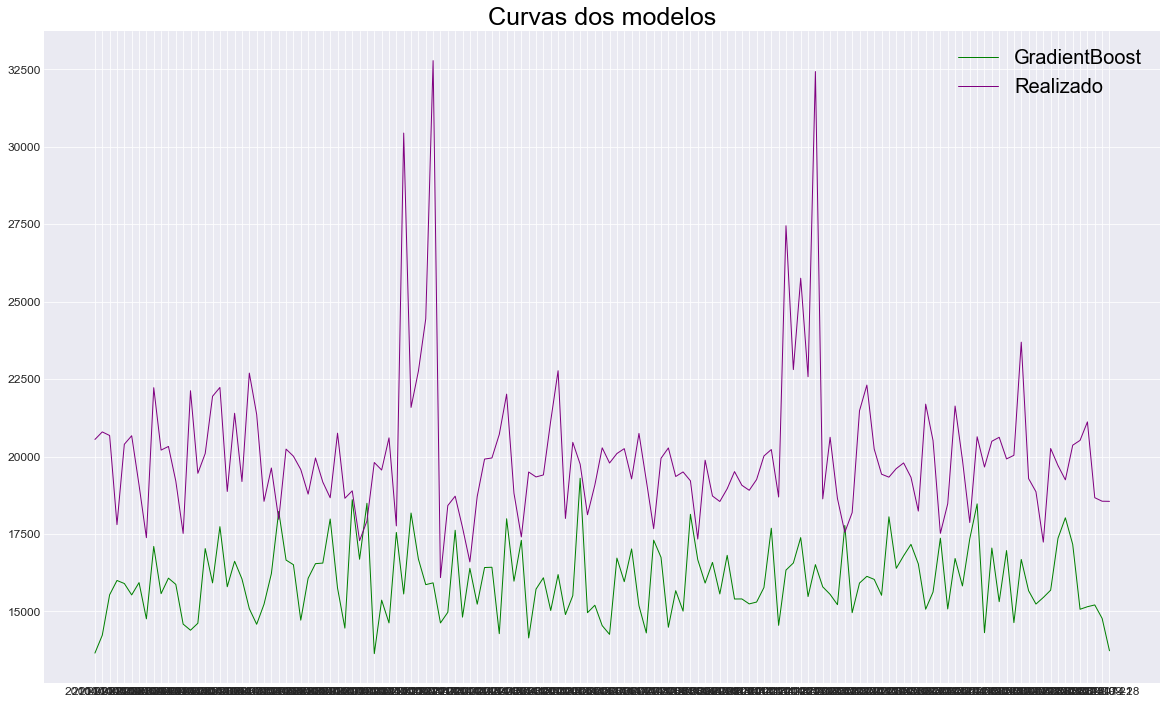

In [139]:
plt.figure(figsize = (20,12))
#plt.plot(linear.loc[linear['Type'] == 'A'].Date,linear.loc[linear['Type'] == 'A'].ln,label='Linear',linewidth=1,color='r')
#plt.plot(forest.loc[forest['Type'] == 'A'].Date,forest.loc[forest['Type'] == 'A'].rf,label='Forest',linewidth=1,color='b')
plt.plot(gbost.loc[gbost['Type'] == 'A'].Date,gbost.loc[gbost['Type'] == 'A'].gbm,label='GradientBoost',linewidth=1,color='g')
plt.plot(real.loc[real['Type'] == 'A'].Date,real.loc[real['Type'] == 'A'].realizado,label='Realizado',linewidth=1,color='purple')
plt.title('Curvas dos modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

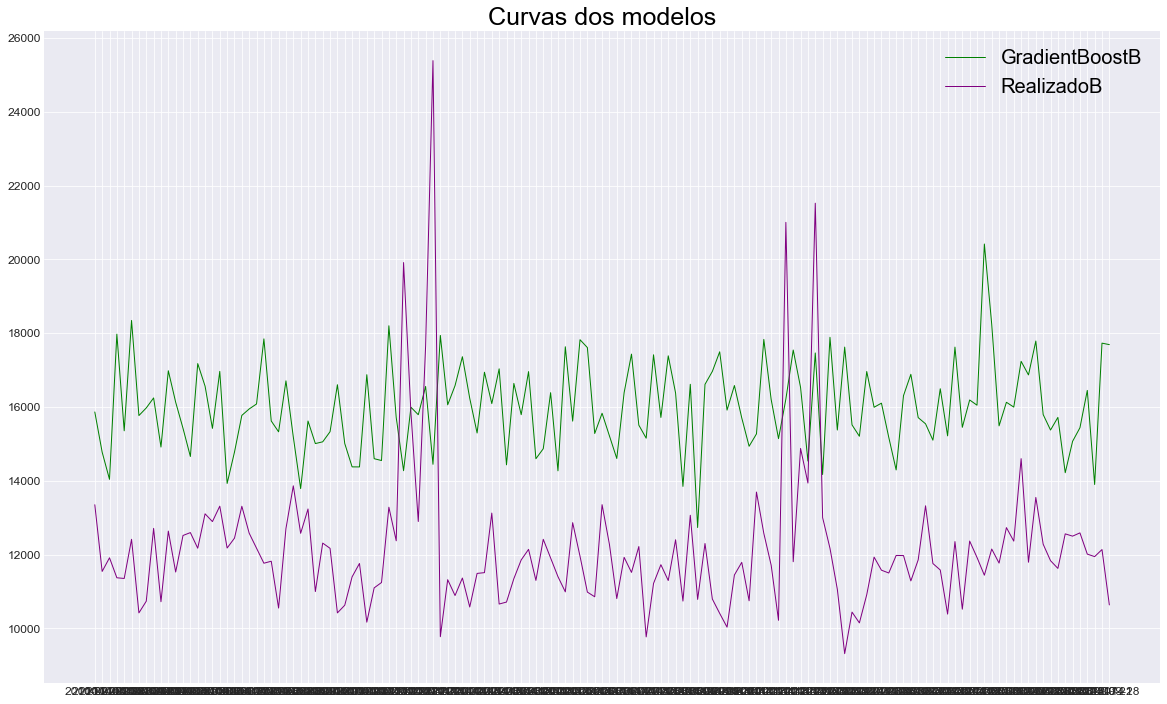

In [140]:
plt.figure(figsize = (20,12))
#plt.plot(gbost.loc[gbost['Type'] == 'A'].Date,gbost.loc[gbost['Type'] == 'A'].gbm,label='GradientBoostA',linewidth=1,color='g')
#plt.plot(real.loc[real['Type'] == 'A'].Date,real.loc[real['Type'] == 'A'].realizado,label='RealizadoA',linewidth=1,color='purple')
plt.plot(gbost.loc[gbost['Type'] == 'B'].Date,gbost.loc[gbost['Type'] == 'B'].gbm,label='GradientBoostB',linewidth=1,color='g')
plt.plot(real.loc[real['Type'] == 'B'].Date,real.loc[real['Type'] == 'B'].realizado,label='RealizadoB',linewidth=1,color='purple')
#plt.plot(gbost.loc[gbost['Type'] == 'C'].Date,gbost.loc[gbost['Type'] == 'C'].gbm,label='GradientBoostC',linewidth=1,color='g')
#plt.plot(real.loc[real['Type'] == 'C'].Date,real.loc[real['Type'] == 'C'].realizado,label='RealizadoC',linewidth=1,color='purple')
plt.title('Curvas dos modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

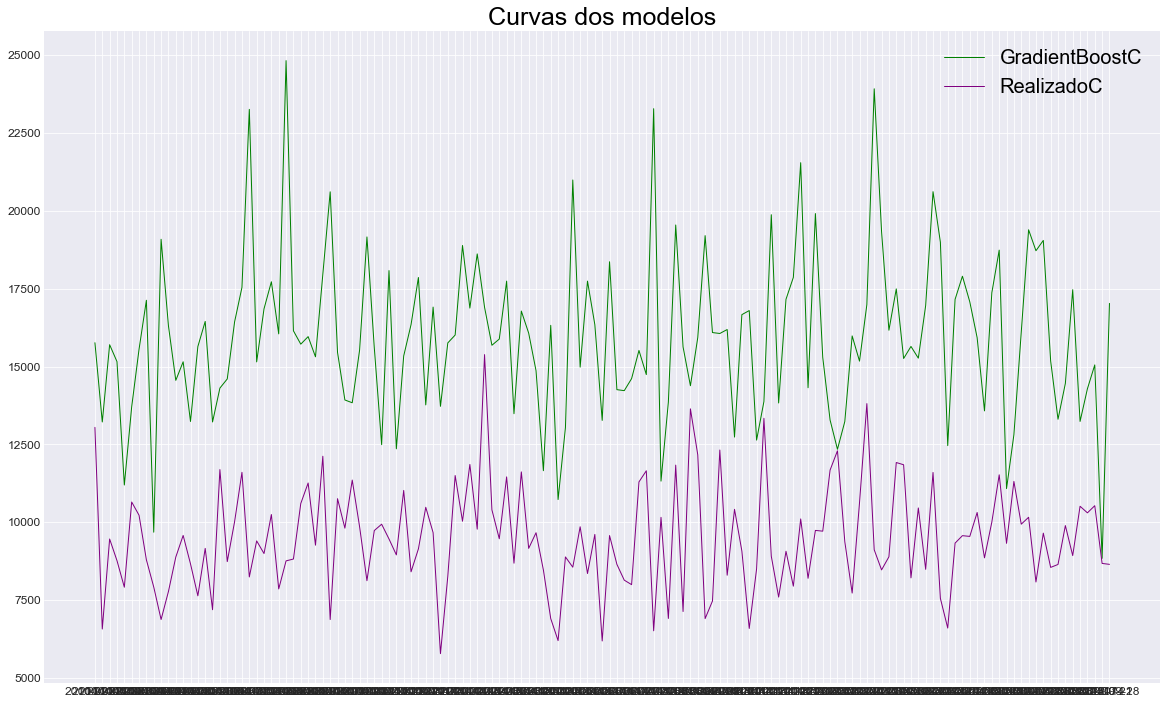

In [141]:
plt.figure(figsize = (20,12))
#plt.plot(gbost.loc[gbost['Type'] == 'A'].Date,gbost.loc[gbost['Type'] == 'A'].gbm,label='GradientBoostA',linewidth=1,color='g')
#plt.plot(real.loc[real['Type'] == 'A'].Date,real.loc[real['Type'] == 'A'].realizado,label='RealizadoA',linewidth=1,color='purple')
#plt.plot(gbost.loc[gbost['Type'] == 'B'].Date,gbost.loc[gbost['Type'] == 'B'].gbm,label='GradientBoostB',linewidth=1,color='g')
#plt.plot(real.loc[real['Type'] == 'B'].Date,real.loc[real['Type'] == 'B'].realizado,label='RealizadoB',linewidth=1,color='purple')
plt.plot(gbost.loc[gbost['Type'] == 'C'].Date,gbost.loc[gbost['Type'] == 'C'].gbm,label='GradientBoostC',linewidth=1,color='g')
plt.plot(real.loc[real['Type'] == 'C'].Date,real.loc[real['Type'] == 'C'].realizado,label='RealizadoC',linewidth=1,color='purple')
plt.title('Curvas dos modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

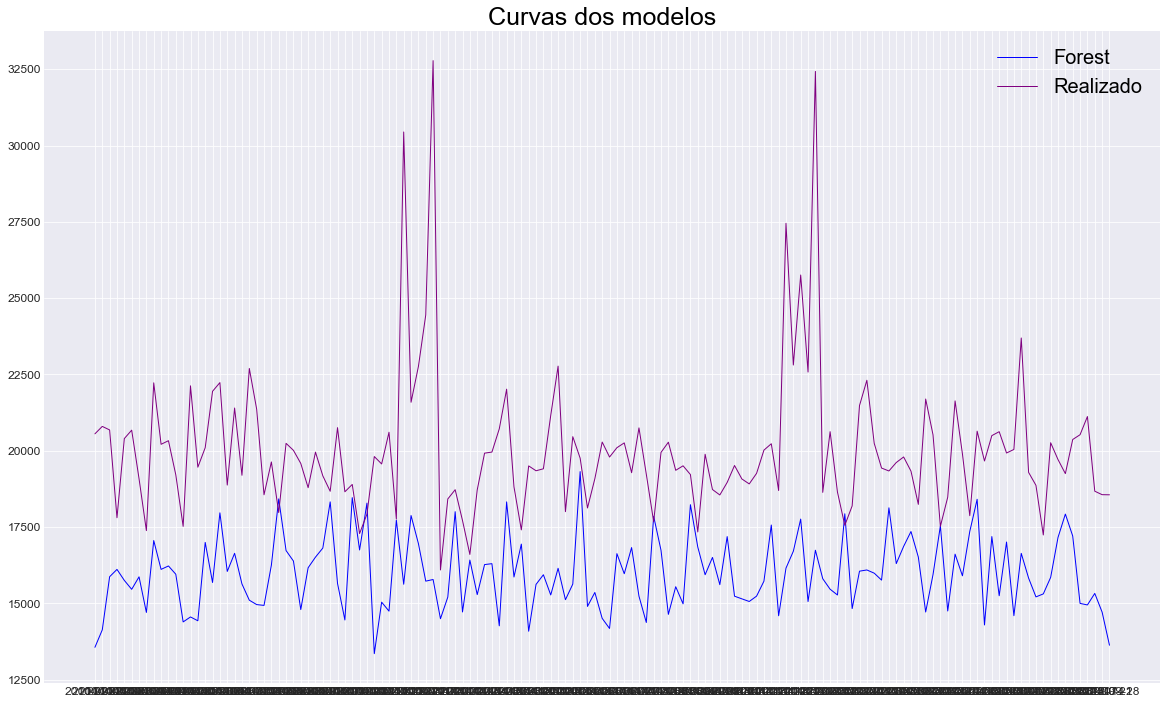

In [143]:
plt.figure(figsize = (20,12))
#plt.plot(linear.loc[linear['Type'] == 'A'].Date,linear.loc[linear['Type'] == 'A'].ln,label='Linear',linewidth=1,color='r')
plt.plot(forest.loc[forest['Type'] == 'A'].Date,forest.loc[forest['Type'] == 'A'].rf,label='Forest',linewidth=1,color='b')
#plt.plot(gbost.loc[gbost['Type'] == 'A'].Date,gbost.loc[gbost['Type'] == 'A'].gbm,label='GradientBoost',linewidth=1,color='g')
plt.plot(real.loc[real['Type'] == 'A'].Date,real.loc[real['Type'] == 'A'].realizado,label='Realizado',linewidth=1,color='purple')
plt.title('Curvas dos modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

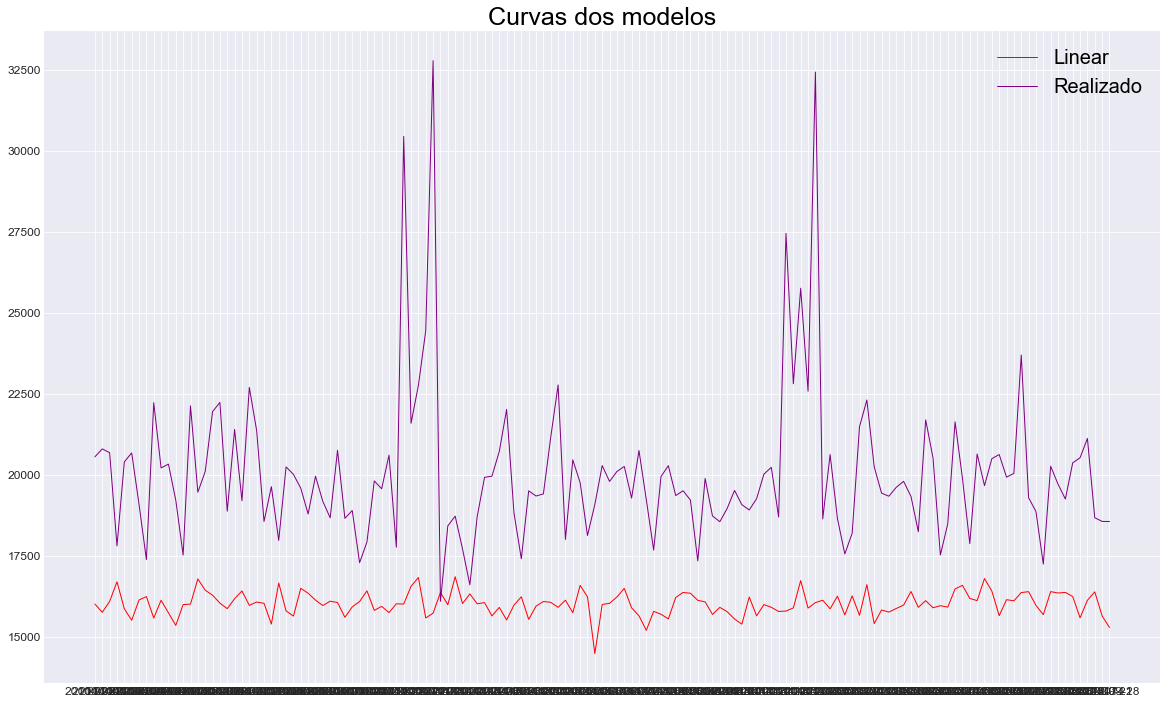

In [144]:
plt.figure(figsize = (20,12))
plt.plot(linear.loc[linear['Type'] == 'A'].Date,linear.loc[linear['Type'] == 'A'].ln,label='Linear',linewidth=1,color='r')
#plt.plot(forest.loc[forest['Type'] == 'A'].Date,forest.loc[forest['Type'] == 'A'].rf,label='Forest',linewidth=1,color='b')
#plt.plot(gbost.loc[gbost['Type'] == 'A'].Date,gbost.loc[gbost['Type'] == 'A'].gbm,label='GradientBoost',linewidth=1,color='g')
plt.plot(real.loc[real['Type'] == 'A'].Date,real.loc[real['Type'] == 'A'].realizado,label='Realizado',linewidth=1,color='purple')
plt.title('Curvas dos modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()

## Teste Modelo por Variável

In [ ]:
X_mod = lojas_limpas.drop(['Weekly_Sales','Date'], axis=1)
y_mod = lojas_limpas['Weekly_Sales']

In [ ]:
mod_c = lojas_limpas.loc[(lojas_limpas['TypeA'] == 0) & (lojas_limpas['TypeB'] == 0)]

In [ ]:
X_mod_c = mod_c.drop(['Weekly_Sales','Date','TypeA','TypeB'], axis=1)
y_mod_c = mod_c['Weekly_Sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mod_c, y_mod_c, test_size=0.2)

In [ ]:
parameters = {'normalize': [False,True], 'fit_intercept': [False,True]} 
model = LinearRegression()

SEED = 1988
np.random.seed(SEED)
cv = KFold(10, shuffle=True)

weight = X_train.IsHoliday*5+1*(1-X_train.IsHoliday)

clf = GridSearchCV(model, parameters, cv=cv, verbose=5, n_jobs=8)
clf.fit(X_train, y_train, sample_weight=weight )
clf.best_params_
clf.predict(X_test)
wmae = WMAE(y_test, clf.predict(X_test), X_test.IsHoliday)
r2 = r2_score(y_test, clf.predict(X_test))
results = cross_validate(model, X, y, cv=cv, return_train_score = False)
media = results['test_score'].mean()
desvio = results['test_score'].std()

print("LinearRegression")
print("------------------------------")
print(f'Parametros ótimos = {clf.best_params_}')
print(f'Mean: {media*100}')
print(f'Accuracy: [{(media-2*desvio)*100} , {(media+2*desvio)*100}]')
print(f'WMAE = {wmae} and R-square = {r2}')
print("------------------------------")

In [ ]:
SEED = 1988
np.random.seed(SEED)
parameters = {'max_depth': [10,20,25,30],'max_features': [6,8,12] , 'n_estimators' : [300, 800, 1600], 'min_samples_leaf' : [2,5]}
model = RandomForestRegressor()


weight = X_train.IsHoliday*5+1*(1-X_train.IsHoliday)

clf = GridSearchCV(model, parameters, cv=10, verbose=5, n_jobs=8)
clf.fit(X_train, y_train, sample_weight=weight )
clf.best_params_
clf.predict(X_test)
wmae = WMAE(y_test, clf.predict(X_test), X_test.IsHoliday)
r2 = r2_score(y_test, clf.predict(X_test))


print("RandomForest")
print("------------------------------")
print(f'Parametros ótimos = {clf.best_params_}')
print(f'WMAE = {wmae} and R-square = {r2}')
print("------------------------------")

In [ ]:
parameters = {'max_depth': [3,5,7], 'max_features': [6,8,12], 'n_estimators' : [300, 800, 1600], 'min_samples_leaf' : [2,5]}
model = GradientBoostingRegressor()

SEED = 1988
np.random.seed(SEED)


weight = X_train.IsHoliday*5+1*(1-X_train.IsHoliday)

clf = GridSearchCV(model, parameters, cv=10, verbose=5, n_jobs=8)
clf.fit(X_train, y_train, sample_weight=weight )
clf.best_params_
clf.predict(X_test)
wmae = WMAE(y_test, clf.predict(X_test), X_test.IsHoliday)
r2 = r2_score(y_test, clf.predict(X_test))

print("GradientBoosting")
print("------------------------------")
print(f'Parametros ótimos = {clf.best_params_}')
print(f'WMAE = {wmae} and R-square = {r2}')
print("------------------------------")

## Análise de resultados

In [ ]:
SEED = 1988
np.random.seed(SEED)
ln = LinearRegression(fit_intercept = True, normalize = False )
rf = RandomForestRegressor(max_depth = 30, max_features =  8, min_samples_leaf = 2 ,n_estimators = 1600)
gbm = GradientBoostingRegressor(max_depth = 5, max_features = 6, min_samples_leaf = 5, n_estimators = 1600)
np.random.seed(SEED)

ln.fit(X_train, y_train)
ln_y_pred = ln.predict(X_test)
wmae_ln_pred = WMAE(y_test, ln_y_pred, X_test.IsHoliday)
r2_ln_pred = r2_score(y_test, ln_y_pred)

rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
wmae_rf_pred = WMAE(y_test, rf_y_pred, X_test.IsHoliday)
r2_rf_pred = r2_score(y_test, rf_y_pred)

gbm.fit(X_train, y_train)
gbm_y_pred = gbm.predict(X_test)
wmae_gbm_pred = WMAE(y_test, gbm_y_pred, X_test.IsHoliday)
r2_gbm_pred = r2_score(y_test, gbm_y_pred)

print("LinearRegression")
print("------------------------------")
print(f'WMAE = {wmae_ln_pred} and R-square = {r2_ln_pred}')
print("------------------------------")
print("RandomForest")
print("------------------------------")
print(f'WMAE = {wmae_rf_pred} and R-square = {r2_rf_pred}')
print("------------------------------")
print("GradientBoosting")
print("------------------------------")
print(f'WMAE = {wmae_gbm_pred} and R-square = {r2_gbm_pred}')
print("------------------------------")

In [ ]:
plt.figure(figsize = (20,12))
plt.scatter(y_test,ln_y_pred,label='LR',marker = 'o',color='r')
plt.scatter(y_test,rf_y_pred,label='RF',marker = 'o',color='b')
plt.scatter(y_test,gbm_y_pred,label='GBR',marker = 'o',color='y')
plt.title('Modelos',fontsize = 25)
plt.legend(fontsize = 20)
plt.show()